In [1]:
import cv2
import numpy as np
import pandas as pd
import torch
import pytorch_model_summary

from timm.scheduler.cosine_lr import CosineLRScheduler

import matplotlib.pyplot as plt
%matplotlib inline

from models.transformer import get_transformer_encoder
from models.anomaly_transformer import get_anomaly_transformer

from utils.datasets import get_data
from utils.functions import masking_matrix

/home/coffeetumbler/anaconda3/envs/ano_trans/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check Transformer Encoder (before adding relative position embedding)

In [8]:
model = get_transformer_encoder(positional_encoding=None)
print(pytorch_model_summary.summary(model, torch.zeros(10, 512, 512), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
    EncoderLayer-1      [10, 512, 512]       3,152,384       3,152,384
    EncoderLayer-2      [10, 512, 512]       3,152,384       3,152,384
    EncoderLayer-3      [10, 512, 512]       3,152,384       3,152,384
    EncoderLayer-4      [10, 512, 512]       3,152,384       3,152,384
    EncoderLayer-5      [10, 512, 512]       3,152,384       3,152,384
    EncoderLayer-6      [10, 512, 512]       3,152,384       3,152,384
Total params: 18,914,304
Trainable params: 18,914,304
Non-trainable params: 0
-----------------------------------------------------------------------


In [6]:
model = get_transformer_encoder(positional_encoding='Sinusoidal')
print(pytorch_model_summary.summary(model, torch.zeros(10, 512, 512), show_input=False))

--------------------------------------------------------------------------------------
                     Layer (type)        Output Shape         Param #     Tr. Param #
   SinusoidalPositionalEncoding-1      [10, 512, 512]               0               0
                   EncoderLayer-2      [10, 512, 512]       3,152,384       3,152,384
                   EncoderLayer-3      [10, 512, 512]       3,152,384       3,152,384
                   EncoderLayer-4      [10, 512, 512]       3,152,384       3,152,384
                   EncoderLayer-5      [10, 512, 512]       3,152,384       3,152,384
                   EncoderLayer-6      [10, 512, 512]       3,152,384       3,152,384
                   EncoderLayer-7      [10, 512, 512]       3,152,384       3,152,384
Total params: 18,914,304
Trainable params: 18,914,304
Non-trainable params: 0
--------------------------------------------------------------------------------------


In [7]:
model = get_transformer_encoder(positional_encoding='Absolute')
print(pytorch_model_summary.summary(model, torch.zeros(10, 512, 512), show_input=False))

-----------------------------------------------------------------------------------
                  Layer (type)        Output Shape         Param #     Tr. Param #
   AbsolutePositionEmbedding-1      [10, 512, 512]         262,144         262,144
                EncoderLayer-2      [10, 512, 512]       3,152,384       3,152,384
                EncoderLayer-3      [10, 512, 512]       3,152,384       3,152,384
                EncoderLayer-4      [10, 512, 512]       3,152,384       3,152,384
                EncoderLayer-5      [10, 512, 512]       3,152,384       3,152,384
                EncoderLayer-6      [10, 512, 512]       3,152,384       3,152,384
                EncoderLayer-7      [10, 512, 512]       3,152,384       3,152,384
Total params: 19,176,448
Trainable params: 19,176,448
Non-trainable params: 0
-----------------------------------------------------------------------------------


## Relative Position Embedding

In [12]:
# Set position index
max_seq_len = 10  # Maximum sequence length example
coords_h = np.arange(max_seq_len)
coords_w = np.arange(max_seq_len-1, -1, -1)
coords = coords_h[:, None] + coords_w[None, :]
print(coords)

[[ 9  8  7  6  5  4  3  2  1  0]
 [10  9  8  7  6  5  4  3  2  1]
 [11 10  9  8  7  6  5  4  3  2]
 [12 11 10  9  8  7  6  5  4  3]
 [13 12 11 10  9  8  7  6  5  4]
 [14 13 12 11 10  9  8  7  6  5]
 [15 14 13 12 11 10  9  8  7  6]
 [16 15 14 13 12 11 10  9  8  7]
 [17 16 15 14 13 12 11 10  9  8]
 [18 17 16 15 14 13 12 11 10  9]]


In [18]:
# Relative position embedding
n_head = 2  # Number of heads example
relative_position_embedding_table = torch.rand(2*max_seq_len-1, n_head)
print('table :')
for i, bias in enumerate(relative_position_embedding_table):
    print(i, ':', bias.numpy())

table :
0 : [0.14965618 0.16788995]
1 : [0.9504504  0.10648322]
2 : [0.3820259  0.26660728]
3 : [0.5858676 0.9569891]
4 : [0.30918825 0.55566347]
5 : [0.5504618 0.6121726]
6 : [0.42828113 0.7249437 ]
7 : [0.69184756 0.5860372 ]
8 : [0.81165934 0.7614068 ]
9 : [0.147039   0.13363111]
10 : [0.93855715 0.44990999]
11 : [0.8766833 0.7013564]
12 : [0.8035398 0.8917592]
13 : [0.7712254  0.45665962]
14 : [0.54262006 0.34000492]
15 : [0.9725495 0.4922533]
16 : [0.8967813  0.36961406]
17 : [0.82937473 0.42501265]
18 : [0.6240979  0.92276263]


In [21]:
relative_position_embedding = relative_position_embedding_table[coords.flatten()].view(max_seq_len, max_seq_len, -1)
relative_position_embedding = relative_position_embedding.permute(2, 0, 1).contiguous()
print('rel pos :')
print('<head 1>')
for i, bias in enumerate(relative_position_embedding[0]):
    print(i, ':', bias.numpy())

rel pos :
<head 1>
0 : [0.147039   0.81165934 0.69184756 0.42828113 0.5504618  0.30918825
 0.5858676  0.3820259  0.9504504  0.14965618]
1 : [0.93855715 0.147039   0.81165934 0.69184756 0.42828113 0.5504618
 0.30918825 0.5858676  0.3820259  0.9504504 ]
2 : [0.8766833  0.93855715 0.147039   0.81165934 0.69184756 0.42828113
 0.5504618  0.30918825 0.5858676  0.3820259 ]
3 : [0.8035398  0.8766833  0.93855715 0.147039   0.81165934 0.69184756
 0.42828113 0.5504618  0.30918825 0.5858676 ]
4 : [0.7712254  0.8035398  0.8766833  0.93855715 0.147039   0.81165934
 0.69184756 0.42828113 0.5504618  0.30918825]
5 : [0.54262006 0.7712254  0.8035398  0.8766833  0.93855715 0.147039
 0.81165934 0.69184756 0.42828113 0.5504618 ]
6 : [0.9725495  0.54262006 0.7712254  0.8035398  0.8766833  0.93855715
 0.147039   0.81165934 0.69184756 0.42828113]
7 : [0.8967813  0.9725495  0.54262006 0.7712254  0.8035398  0.8766833
 0.93855715 0.147039   0.81165934 0.69184756]
8 : [0.82937473 0.8967813  0.9725495  0.54262006 

In [22]:
coords.flatten()

array([ 9,  8,  7,  6,  5,  4,  3,  2,  1,  0, 10,  9,  8,  7,  6,  5,  4,
        3,  2,  1, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  5, 15, 14, 13, 12, 11, 10,  9,  8,
        7,  6, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7, 17, 16, 15, 14, 13,
       12, 11, 10,  9,  8, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9])

In [2]:
# Check Transformer encoder with relative position embedding
model = get_transformer_encoder(positional_encoding=None, relative_position_embedding=True)
print(pytorch_model_summary.summary(model, torch.zeros(10, 512, 512), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
    EncoderLayer-1      [10, 512, 512]       3,160,568       3,160,568
    EncoderLayer-2      [10, 512, 512]       3,160,568       3,160,568
    EncoderLayer-3      [10, 512, 512]       3,160,568       3,160,568
    EncoderLayer-4      [10, 512, 512]       3,160,568       3,160,568
    EncoderLayer-5      [10, 512, 512]       3,160,568       3,160,568
    EncoderLayer-6      [10, 512, 512]       3,160,568       3,160,568
Total params: 18,963,408
Trainable params: 18,963,408
Non-trainable params: 0
-----------------------------------------------------------------------


## Check Anomaly Transformer

In [3]:
# Summary the example model.
model = get_anomaly_transformer(d_data=10,
                                d_embed=64,
                                hidden_dim_rate=4.,
                                max_seq_len=100,
                                mask_token_rate=(0.05,0.15),
                                positional_encoding=None,
                                relative_position_embedding=True,
                                transformer_n_layer=3,
                                transformer_n_head=4,
                                dropout=0.1)
print(pytorch_model_summary.summary(model, torch.zeros(16, 100, 10), show_input=False))

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Linear-1       [16, 100, 64]             704             704
   TransformerEncoder-2       [16, 100, 64]         152,340         152,340
               Linear-3      [16, 100, 256]          16,640          16,640
                 GELU-4      [16, 100, 256]               0               0
               Linear-5       [16, 100, 10]           2,570           2,570
Total params: 172,254
Trainable params: 172,254
Non-trainable params: 0
----------------------------------------------------------------------------


In [3]:
# Check model instances.
print(model.mask_token_table[:10])
print()
print(model.mask_token)

[14, 6, 14, 12, 8, 12, 10, 11, 10, 14]

Parameter containing:
tensor([[ 0.0053, -0.0057, -0.0327,  0.0048,  0.0043, -0.0022, -0.0176, -0.0310,
         -0.0053,  0.0069, -0.0078,  0.0106,  0.0044,  0.0415, -0.0048, -0.0029,
          0.0119, -0.0117,  0.0170,  0.0006, -0.0185,  0.0253, -0.0154, -0.0067,
         -0.0159, -0.0109,  0.0060, -0.0160,  0.0078,  0.0099,  0.0308,  0.0719,
          0.0068, -0.0020, -0.0179,  0.0115,  0.0029,  0.0234, -0.0004,  0.0065,
          0.0188, -0.0159, -0.0118, -0.0079, -0.0005, -0.0236, -0.0139,  0.0228,
          0.0358,  0.0157, -0.0106,  0.0102, -0.0012,  0.0266,  0.0271, -0.0069,
          0.0165, -0.0182, -0.0007,  0.0148,  0.0243,  0.0238, -0.0059, -0.0005]],
       requires_grad=True)


In [5]:
# Check autograd functions.
l1_loss = torch.nn.L1Loss()

x = torch.rand(16, 100, 10)
y = model(x)
loss = l1_loss(x, y)
print('loss :', loss.item())

loss : 2.413358211517334


In [6]:
loss.backward()
print(model.linear_embedding.bias.grad)

tensor([-0.2086, -0.2762,  0.2535,  1.0324,  0.1024,  0.0914,  0.9866, -0.5405,
         0.3809, -0.0159,  0.4031,  0.1038,  0.8071, -0.4886, -0.3818, -0.1702,
         1.0533,  0.5017, -0.2825, -0.7611, -0.3886,  0.7570,  0.8553, -0.0265,
         0.0247, -0.4464,  0.1729, -0.0541,  0.0444,  0.1384, -0.3599, -0.4125,
         0.0700,  0.4699, -0.2983, -0.3459,  0.1212,  0.3143, -0.2653,  0.5975,
         0.3497,  0.0197,  0.1166, -0.0435, -0.5129,  0.4491, -0.4168,  0.1174,
        -0.2196, -0.2135, -0.0068, -1.2207,  0.1179, -0.0373, -0.1633, -0.3557,
        -0.5474, -0.8561,  0.5296,  0.0873, -0.8980, -0.6438,  0.2070, -0.0990])


In [7]:
print(model.mask_token.grad)

tensor([[-0.5545, -0.7614,  0.4503,  0.7524,  0.0604, -0.4823,  0.4422,  0.8438,
          1.0116,  0.7272,  0.1171,  0.6688,  0.7854,  0.0084,  0.6613,  0.5270,
          0.6445,  0.1250,  1.0520, -1.3416,  1.2106,  0.8090,  0.1353,  0.4056,
          0.4472, -1.2009, -0.8700, -1.2629,  0.5274, -0.5598, -0.2111,  0.1449,
          0.7595,  1.2007,  0.3101, -1.2605,  0.2475, -0.2101, -0.7676,  1.1885,
          0.7706,  0.4547, -0.6664, -0.9339, -1.1345, -0.4515, -0.1796,  1.0323,
         -0.5746, -0.0408,  0.2519, -0.4176,  0.1028, -1.4091, -0.1960, -1.2700,
         -1.6909, -1.5927, -0.2550,  0.4100, -0.2361,  0.4618,  0.0729,  0.6517]])


In [8]:
print(model.transformer_encoder.encoder_layers[0].attention_layer.relative_position_embedding_table.grad[:10])

tensor([[-1.7156e-05, -6.6179e-06,  2.1336e-06, -1.0048e-05],
        [-2.6890e-05, -2.2301e-06,  1.1036e-05,  1.2869e-06],
        [-2.6311e-05,  6.2818e-06,  9.8580e-06, -3.8717e-07],
        [-1.3054e-05, -4.7467e-06,  1.4798e-05,  8.6596e-06],
        [-2.4838e-05, -5.9972e-06,  2.3861e-05,  3.2242e-05],
        [-2.4469e-05,  3.4905e-06,  2.1670e-05,  2.0059e-05],
        [-3.3681e-05, -6.1303e-06,  4.3800e-05,  2.1766e-05],
        [-2.6824e-05,  1.8091e-05,  6.1962e-05,  1.0274e-05],
        [-4.8427e-05,  1.8547e-06,  7.4820e-05,  3.0014e-05],
        [-4.1165e-05, -1.0241e-05,  9.8454e-05,  3.9157e-05]])


## Train Anomaly Transformer

In [2]:
# SMAP dataset
(train_smap, _), (test_smap, test_label_smap) = get_data('SMAP')

load data of: SMAP
train:  0 None
test:  0 None
Data normalized
Data normalized
train set shape:  (138004, 25)
test set shape:  (435826, 25)
test set label shape:  (435826,)


In [3]:
# Define model.
device = torch.device('cuda')
model = get_anomaly_transformer(d_data=25,
                                d_embed=512,
                                hidden_dim_rate=4.,
                                max_seq_len=512,
                                mask_token_rate=(0,0),
                                positional_encoding=None,
                                relative_position_embedding=True,
                                transformer_n_layer=6,
                                transformer_n_head=8,
                                dropout=0.1).to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/220524_smap_test_4/model.pt'

0.38426939438882146
[False False False  True False  True False False  True False  True False
 False False False  True  True  True False  True  True  True  True  True
  True]


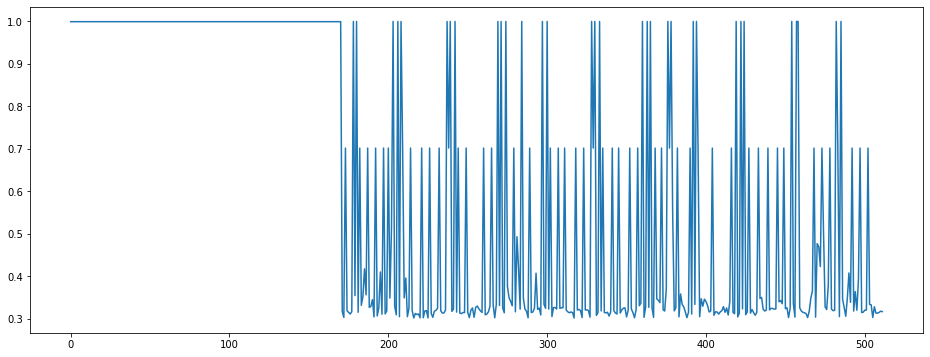

In [147]:
# Replacing example
index = 4

# print(soft_replacing[index])
# print(uniform_replacing[index])
# print(peak_nosing[index])

print(replacing_type[index])
print(replacing_dim[index])

plt.figure(figsize=(16, 6))
plt.plot(x[index][:, 0].cpu())
plt.show()

# plt.figure(figsize=(16, 4))
# plt.plot(x[index][:, 1].cpu())
# plt.show()

# plt.figure(figsize=(16, 4))
# plt.plot(x[index][:, 2].cpu())
# plt.show()

# plt.figure(figsize=(16, 4))
# plt.plot(x[index][:, 3].cpu())
# plt.show()

torch.Size([16, 512, 25])
torch.Size([16, 512, 25])


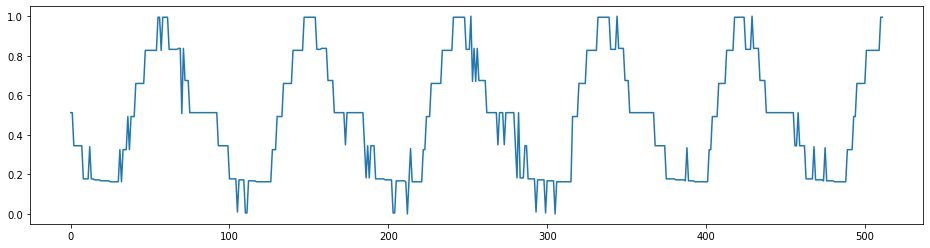

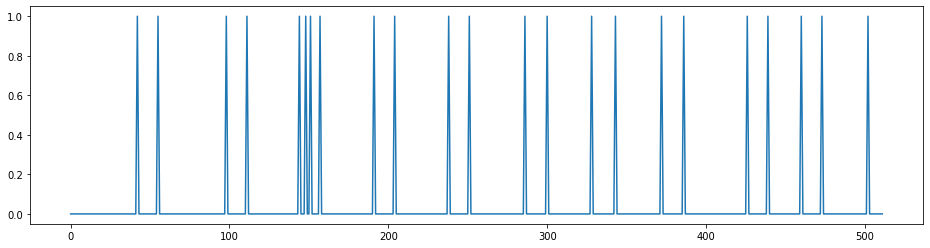

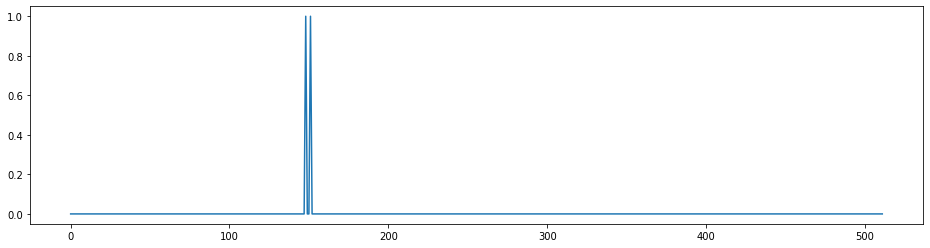

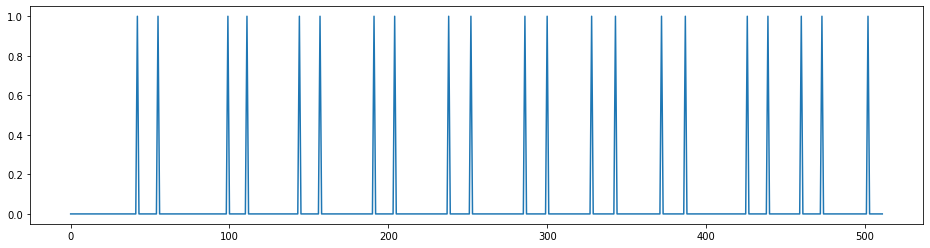

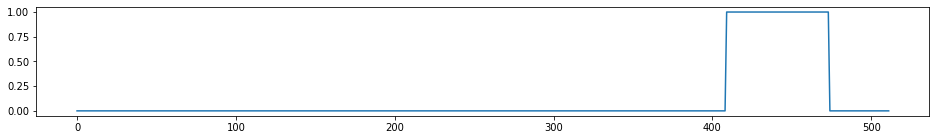

In [134]:
# Replacing example
print(z.shape)
print(x_true.shape)

plt.figure(figsize=(16, 4))
plt.plot(x_true[index][:, 0].cpu().detach().numpy())
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(x_true[index][:, 1].cpu().detach().numpy())
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(x_true[index][:, 2].cpu().detach().numpy())
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(x_true[index][:, 3].cpu().detach().numpy())
plt.show()

plt.figure(figsize=(16, 2))
plt.plot(x_anomaly[index].cpu().detach().numpy())
plt.show()

In [130]:
# Train model.
max_iters = 50000
window_size = 512
n_batch = 16
valid_index_list = np.arange(len(train_smap) - window_size)

device = torch.device('cpu')

rec_loss = torch.nn.L1Loss().to(device)
# optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0001, weight_decay=1e-4)
# scheduler = CosineLRScheduler(optimizer,
#                               t_initial=max_iters,
#                               lr_min=0.0001*0.01,
#                               warmup_lr_init=1e-7,
#                               warmup_t=max_iters // 10,
#                               cycle_limit=1,
#                               t_in_epochs=False,
#                              )

# Replaced data length table
replacing_rate = (0, 0.15)
replacing_table = list(np.random.randint(int(window_size*replacing_rate[0]), int(window_size*replacing_rate[1]), size=10000))
replacing_table_index = 0
replacing_table_length = 10000
d_data = 25
numerical_column = (0,)

for i in range(max_iters):
    first_index = np.random.choice(valid_index_list, size=n_batch)
    x = []
    for j in first_index:
        x.append(torch.Tensor(train_smap[j:j+window_size].copy()))
    x_true = torch.stack(x).to(device)
    
    # Replace data (soft replacing)
    current_index = replacing_table_index
    replacing_table_index += n_batch

    replacing_lengths = []
    if replacing_table_index > replacing_table_length:
        replacing_lengths = replacing_table[current_index:]
        replacing_table_index -= replacing_table_length
        replacing_lengths = replacing_lengths + replacing_table[:replacing_table_index]
    else:
        replacing_lengths = replacing_table[current_index:replacing_table_index]
        if replacing_table_index == replacing_table_length:
            replacing_table_index = 0
    
    replacing_lengths = np.array(replacing_lengths)
    replacing_index = np.random.randint(0, len(train_smap)-replacing_lengths+1)
    target_index = np.random.randint(0, window_size-replacing_lengths+1)
    
    # Replacing type
    replacing_type = np.random.uniform(0., 1., size=(n_batch,))
    replacing_dim = np.random.uniform(0., 1., size=(n_batch, d_data)) > 0.5

    x_rep = []  # list of replaced intervals
    x_anomaly = torch.zeros(n_batch, window_size, device=device)  # list of anomaly points

    # Create anomaly intervals.
    for j, rep, tar, leng, typ, dim in zip(range(n_batch), replacing_index, target_index, replacing_lengths,
                                           replacing_type, replacing_dim):
        if leng > 0:
            x_rep.append(x[j][tar:tar+leng].clone())
            _x = x_rep[-1].clone().transpose(0, 1)
            rep_len = len(dim[dim])

            if typ > 0.75:
                _x_temp = _x[numerical_column]
                _x[dim] = torch.Tensor(train_smap[rep:rep+leng, dim].copy()).transpose(0, 1)
                _x[numerical_column] = (_x_temp + _x[numerical_column]) * 0.5
                x_anomaly[j, tar:tar+leng] = 1

            elif typ > 0.5:
                _x[numerical_column] = torch.rand(len(numerical_column), 1)
                x_anomaly[j, tar:tar+leng] = 1

            elif typ < 0.25:
                peak_index = np.random.randint(0, leng)
                peak_value = (_x[dim, peak_index] < 0.5).float()
                _x[dim, peak_index] = peak_value
                x_anomaly[j, tar+peak_index] = 1

            else:
                x_rep[-1] = None

            x[j][tar:tar+leng] = _x.transpose(0, 1)

        else:
            x_rep.append(None)
            
    z = torch.stack(x).to(device)
    if i > 1:
        break
#     y = model(x) + x
    
#     loss = rec_loss(x_true, y)
#     if i % 500 == 0:
#         print('iter ', i, ', loss : ', loss.item(), ', original loss :', rec_loss(x, x_true).item(), sep='')
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     scheduler.step_update(i)

# torch.save(model.state_dict(), 'logs/220524_smap_test_4/state_dict.pt')

In [42]:
# Check binary columns.
for i, column in enumerate(np.transpose(np.concatenate((train_smap, test_smap), axis=0))):
    if len(column[(column < 1) & (column > 0)]) < 1:
        print(i+1)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [11]:
# Check anomaly sequences.
anomaly_args = np.argwhere(test_label_smap).flatten()
terms = anomaly_args[1:] - anomaly_args[:-1]
terms = terms > 1

sequence_args = np.argwhere(terms).flatten() + 1
sequence_length = list(sequence_args[1:] - sequence_args[:-1])
sequence_args = list(sequence_args)

sequence_args.insert(0, 0)
sequence_length.insert(0, sequence_args[1])
sequence_length.append(len(anomaly_args) - sequence_args[-1])

sequence_args = anomaly_args[sequence_args]
print(sequence_args)
print(sequence_length)
print(sum(sequence_length))

[  4690  13090  21129  29309  35589  39422  48185  55185  63560  72485
  80719  88248  96587 104397 111309 120810 129450 137498 145196 153150
 160222 169976 176132 176742 184648 185249 193153 193767 201667 202277
 210488 210779 211628 219417 227445 236108 244612 252916 261000 269316
 277998 286142 295003 303560 311106 318835 326366 334763 343305 349995
 351395 353905 356523 357913 358910 368280 372322 373522 376142 384105
 391736 399770 404200 408351 417253 421136 424238]
[85, 111, 186, 111, 51, 41, 2401, 3806, 3865, 71, 3259, 61, 2740, 161, 4218, 3276, 3248, 51, 81, 2702, 51, 1156, 31, 477, 51, 271, 51, 244, 51, 532, 102, 41, 121, 1398, 3213, 2812, 321, 66, 281, 623, 351, 101, 2957, 41, 121, 41, 51, 31, 101, 101, 51, 116, 201, 241, 309, 1336, 131, 201, 111, 1651, 81, 448, 1500, 36, 1785, 83, 101]
54696


In [5]:
# Save checkpoint.
torch.save(model, 'logs/220523_smap_test/model.pt')
torch.save(model.state_dict(), 'logs/220523_smap_test/state_dict.pt')

In [8]:
# Check instances.
print(model.mask_token[0, :10])

tensor([-0.0083,  0.0386,  0.0112,  0.0171,  0.0163,  0.0049, -0.0006, -0.0037,
        -0.0138,  0.0028], device='cuda:0', grad_fn=<SliceBackward>)


In [5]:
print(model.transformer_encoder.encoder_layers[0].attention_layer.relative_position_embedding_table[:10])
print(model.transformer_encoder.encoder_layers[0].attention_layer.relative_position_embedding_table[507:517])
print(model.transformer_encoder.encoder_layers[0].attention_layer.relative_position_embedding_table[-10:])

tensor([[ 0.0416,  0.0032,  0.0818, -0.0199,  0.0690,  0.0124,  0.0489,  0.0211],
        [ 0.0847,  0.0841,  0.0676,  0.1078,  0.0391,  0.1128,  0.0598,  0.0578],
        [ 0.0713,  0.1236,  0.0566,  0.1277,  0.1399,  0.0906,  0.1320,  0.1264],
        [ 0.0794,  0.0570,  0.0930,  0.0869,  0.0683,  0.0973,  0.0889,  0.1009],
        [ 0.1437,  0.0824,  0.1513,  0.1084,  0.1105,  0.0658,  0.0617,  0.1009],
        [ 0.1023,  0.1301,  0.0940,  0.1169,  0.0949,  0.1380,  0.1353,  0.0898],
        [ 0.1202,  0.1586,  0.1105,  0.1294,  0.1294,  0.1121,  0.1089,  0.1502],
        [ 0.1094,  0.0723,  0.1403,  0.1149,  0.1330,  0.1149,  0.0902,  0.1404],
        [ 0.1386,  0.1489,  0.1327,  0.1245,  0.0871,  0.1009,  0.1175,  0.0867],
        [ 0.0862,  0.0919,  0.0924,  0.1543,  0.1522,  0.0882,  0.1008,  0.1363]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ 0.5179,  0.5591,  0.5294,  0.5556,  0.5204,  0.5458,  0.5164,  0.5556],
        [ 0.4722,  0.4967,  0.5299,  0.4927,  0.

In [6]:
print(model.transformer_encoder.encoder_layers[1].attention_layer.relative_position_embedding_table[:10])
print(model.transformer_encoder.encoder_layers[1].attention_layer.relative_position_embedding_table[507:517])
print(model.transformer_encoder.encoder_layers[1].attention_layer.relative_position_embedding_table[-10:])

tensor([[ 0.0219, -0.0186,  0.0367, -0.0401,  0.0345, -0.0011,  0.0197,  0.0063],
        [ 0.0357,  0.0377,  0.0128,  0.0414, -0.0074,  0.0472,  0.0048,  0.0137],
        [ 0.0108,  0.0506, -0.0099,  0.0346,  0.0452,  0.0125,  0.0511,  0.0360],
        [-0.0002, -0.0040,  0.0163,  0.0069, -0.0039,  0.0063,  0.0115,  0.0240],
        [ 0.0363,  0.0120,  0.0530,  0.0183,  0.0228, -0.0255, -0.0288,  0.0226],
        [ 0.0032,  0.0260,  0.0030,  0.0150,  0.0018,  0.0217,  0.0278, -0.0036],
        [ 0.0037,  0.0415,  0.0016,  0.0253,  0.0286,  0.0138,  0.0134,  0.0320],
        [ 0.0135, -0.0175,  0.0221,  0.0074,  0.0310,  0.0267, -0.0051,  0.0339],
        [ 0.0268,  0.0407,  0.0186,  0.0246, -0.0080, -0.0053,  0.0141, -0.0050],
        [-0.0012,  0.0004, -0.0076,  0.0346,  0.0275, -0.0107,  0.0109,  0.0281]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ 0.1640,  0.1876,  0.1647,  0.1810,  0.1908,  0.1697,  0.1844,  0.1820],
        [ 0.2295,  0.2533,  0.2469,  0.2585,  0.

In [2]:
# SMAP dataset
(train_smap, _), (test_smap, test_label_smap) = get_data('SMAP')

load data of: SMAP
train:  0 None
test:  0 None
Data normalized
Data normalized
train set shape:  (138004, 25)
test set shape:  (435826, 25)
test set label shape:  (435826,)


In [50]:
# Load model.
model = torch.load('logs/220613225259_smap_test/model.pt', map_location='cpu')
model.load_state_dict(torch.load('logs/220613225259_smap_test/state_dict.pt', map_location='cpu'))
# model.load_state_dict(torch.load('logs/220602142216_smap_test/state/state_dict_step_90000.pt', map_location='cpu'))
device = torch.device('cpu')

In [51]:
# Evaluation metrics
l1_loss = torch.nn.L1Loss().to(device)
mse = torch.nn.MSELoss().to(device)
accuracy = lambda scores, labels : ((scores > 0.5) == labels).float().mean()

In [29]:
def similarity_map(features):
    similarity = torch.matmul(features, features.transpose(-1, -2))
    norms = torch.norm(features, dim=-1)
    denom = torch.matmul(norms.unsqueeze(-1), norms.unsqueeze(-2))
    return similarity / denom

def draw_map(similarity_maps):
    for j, _map in enumerate(similarity_maps):
        img = ((_map + 1) / 2).cpu().numpy()
        img = np.repeat(img[:, :, None], 3, axis=-1)
        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        plt.show()

In [52]:
# Test model.
model.eval()
model.mask_input = False

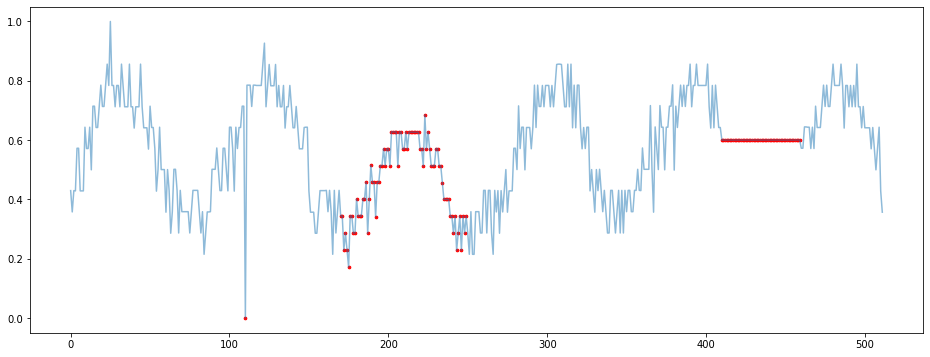

In [11]:
x = torch.Tensor(test_x.copy()).unsqueeze(0)
anomaly_args = range(410, 460)
_anomaly_args = range(170, 250)
x[0, anomaly_args, 0] = 0.6
x[0, 110, 0] = 0
x[0, _anomaly_args, 0] *= 0.8

plt.figure(figsize=(16, 6))
plt.plot(x[0, :,0], alpha=0.5)
plt.scatter(anomaly_args, x[0, anomaly_args, 0], color='red', s=7)
plt.scatter(_anomaly_args, x[0, _anomaly_args, 0], color='red', s=7)
plt.scatter((110,), x[0, 110, 0], color='red', s=7)
plt.show()

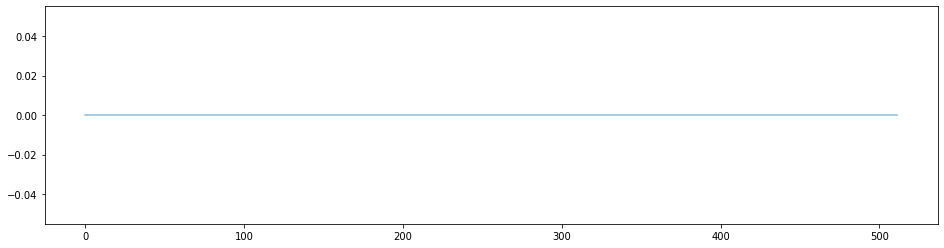

In [73]:
# i = 13000
i = 133000
j = i + 512

test_x = test_smap[i:j]
test_label = test_label_smap[i:j]
anomaly_args = np.argwhere(test_label).flatten()

plt.figure(figsize=(16, 4))
plt.plot(test_x[:, 0], alpha=0.5)
plt.scatter(anomaly_args, test_x[anomaly_args, 0], color='red', s=5)
plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 1], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 1], color='red', s=5)
# plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 2], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 2], color='red', s=5)
# plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 3], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 3], color='red', s=5)
# plt.show()

In [54]:
with torch.no_grad():
    x = torch.Tensor(test_x).unsqueeze(0).to(device)
#     y = model(x)
    
    y, scores = model(x)
    anomaly = torch.Tensor(test_label).unsqueeze(0).to(device)

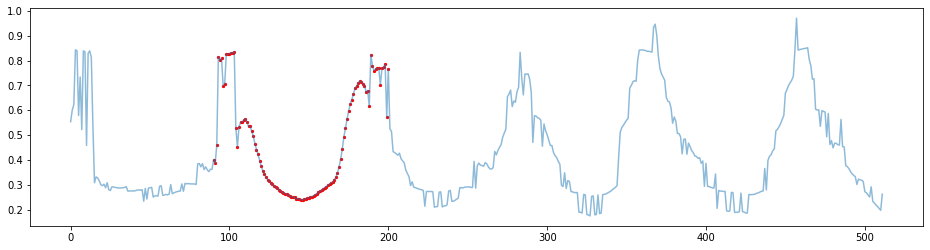

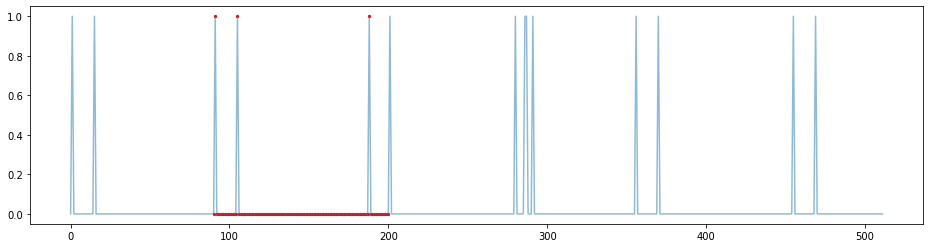

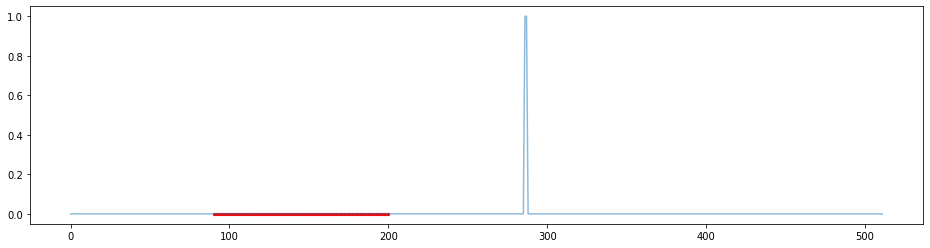

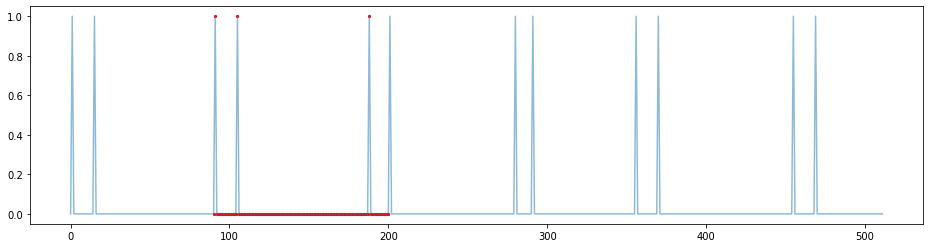

In [55]:
plt.figure(figsize=(16, 4))
plt.plot(y[0, :, 0].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 0].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(y[0, :, 1].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 1].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(y[0, :, 2].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 2].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(y[0, :, 3].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 3].cpu().detach().numpy(), color='red', s=5)
plt.show()

# plt.figure(figsize=(16, 4))
# # plt.ylim((0, 0.005))
# plt.plot(scores[0].cpu().detach().numpy(), alpha=0.5)
# plt.scatter(anomaly_args, scores[0, anomaly_args].cpu().detach().numpy(), color='red', s=5)
# plt.show()

# print(scores[0, 256])

# sim_map = similarity_map(scores)
# draw_map(sim_map)
# draw_map(sim_map > 0.95)
# print(sim_map.min())

# sim_sum = sim_map.sum(dim=-1)
# plt.figure(figsize=(16, 6))
# plt.plot(sim_sum[0].numpy(), alpha=0.5)
# plt.scatter(anomaly_args, sim_sum[0, anomaly_args], color='red', s=5)
# plt.show()

# print(sim_sum.sum())
# print(torch.exp(sim_map).sum())
# print(torch.exp(-sim_map).sum())

# sim_sum = (sim_map > -0.7).sum(dim=-1)
# plt.figure(figsize=(16, 6))
# plt.plot(sim_sum[0].numpy())
# plt.show()

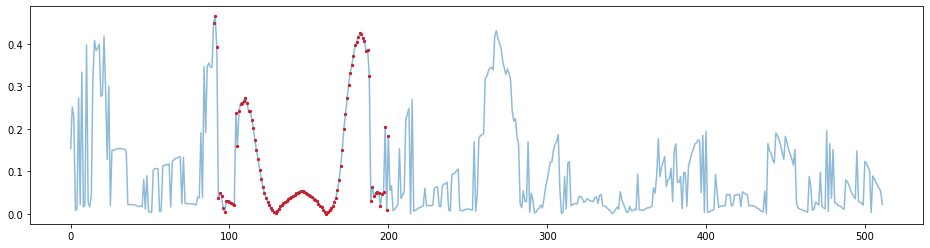

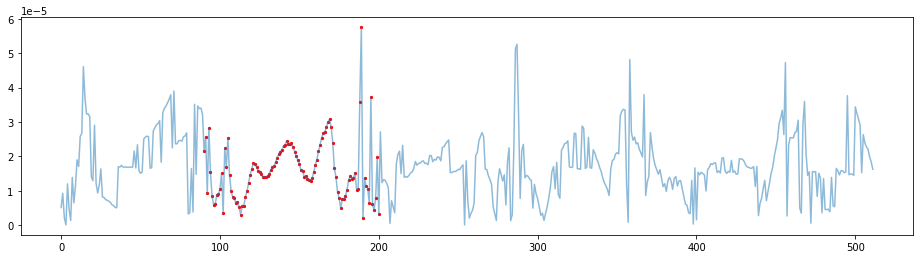

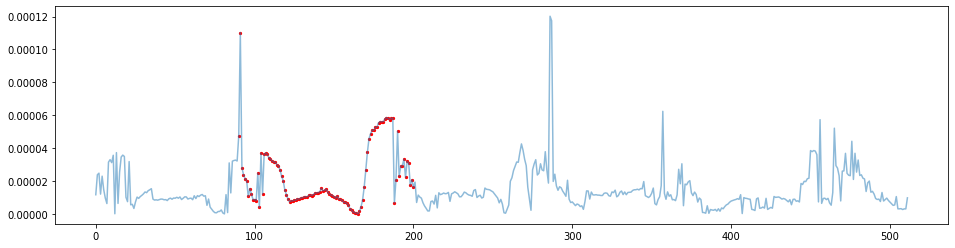

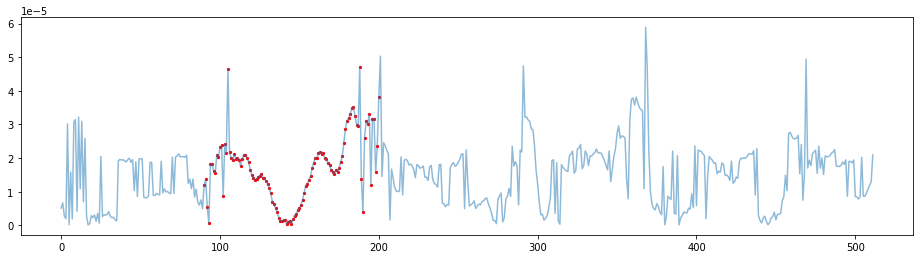

In [56]:
diff = (y - x).abs().cpu().detach().numpy()

plt.figure(figsize=(16, 4))
plt.plot(diff[0, :, 0], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 0], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(diff[0, :, 1], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 1], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(diff[0, :, 2], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 2], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(diff[0, :, 3], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 3], color='red', s=5)
plt.show()

In [57]:
print('l1 loss :', l1_loss(x, y).item())
print('mse loss :', mse(x, y).item())
# print('accuracy :', accuracy(scores, anomaly).item())

l1 loss : 0.003908750135451555
mse loss : 0.0008686129003763199


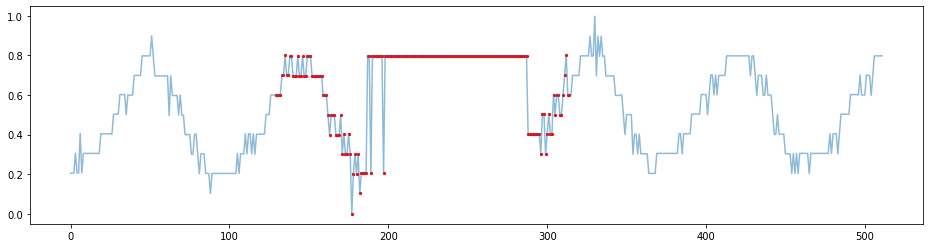

In [58]:
i = 21000
j = i + 512

test_x = test_smap[i:j]
test_label = test_label_smap[i:j]
anomaly_args = np.argwhere(test_label).flatten()

plt.figure(figsize=(16, 4))
plt.plot(test_x[:, 0], alpha=0.5)
plt.scatter(anomaly_args, test_x[anomaly_args, 0], color='red', s=5)
plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 1], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 1], color='red', s=5)
# plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 2], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 2], color='red', s=5)
# plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 3], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 3], color='red', s=5)
# plt.show()

In [59]:
with torch.no_grad():
    x = torch.Tensor(test_x).unsqueeze(0).to(device)
#     y = model(x)
    y, scores = model(x)
    anomaly = torch.Tensor(test_label).unsqueeze(0).to(device)

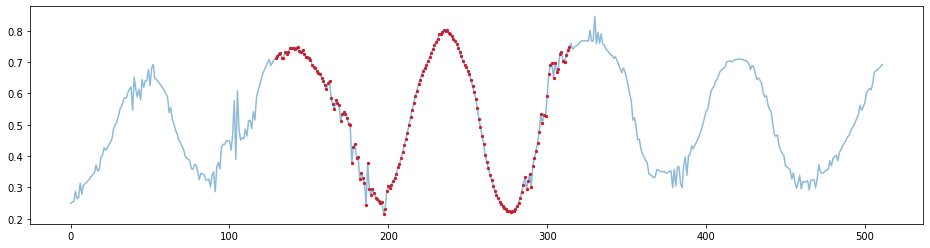

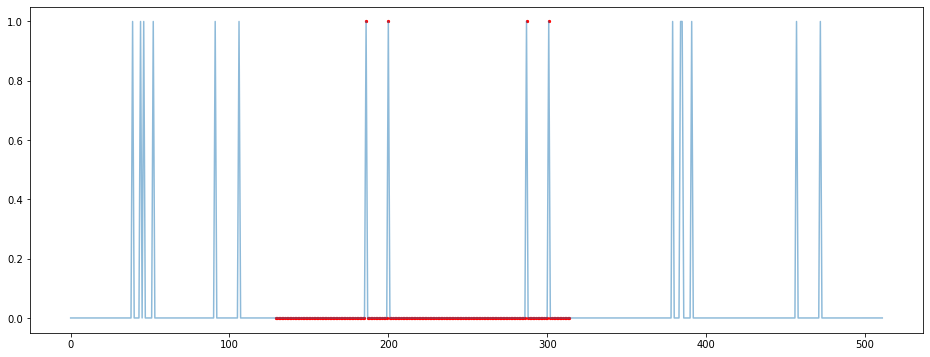

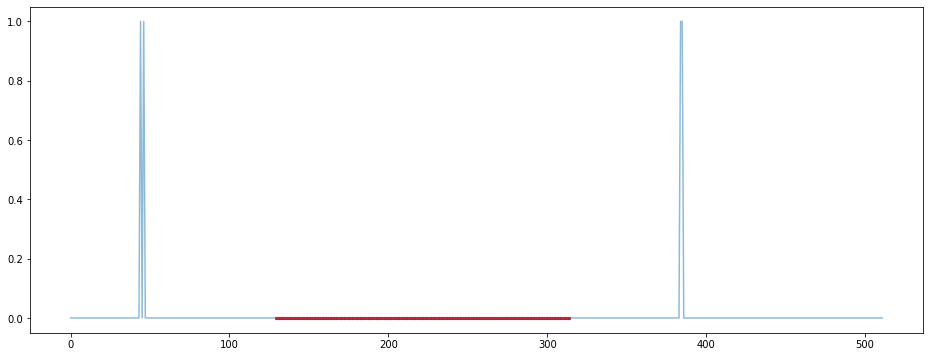

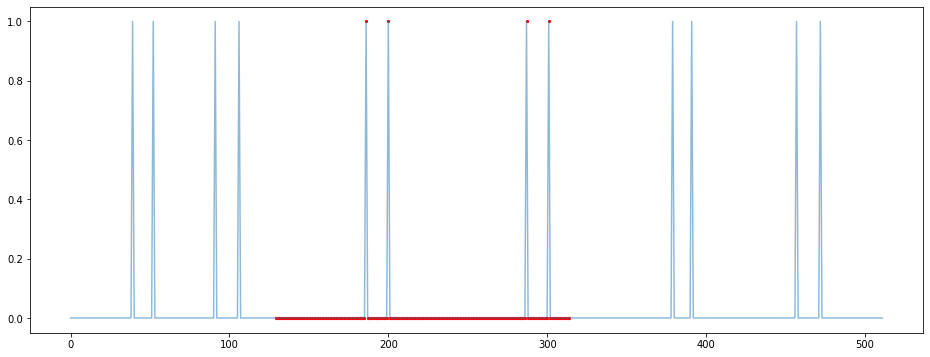

In [60]:
plt.figure(figsize=(16, 4))
plt.plot(y[0, :, 0].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 0].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(y[0, :, 1].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 1].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(y[0, :, 2].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 2].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(y[0, :, 3].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 3].cpu().detach().numpy(), color='red', s=5)
plt.show()

# plt.figure(figsize=(16, 4))
# # plt.ylim((0, 0.005))
# plt.plot(scores[0].cpu().detach().numpy(), alpha=0.5)
# plt.scatter(anomaly_args, scores[0, anomaly_args].cpu().detach().numpy(), color='red', s=5)
# plt.show()

# print(scores[0, 256])

# sim_map = similarity_map(scores)
# draw_map(sim_map)
# draw_map(sim_map > 0.95)
# print(sim_map.min())

# sim_sum = sim_map.sum(dim=-1)
# plt.figure(figsize=(16, 6))
# plt.plot(sim_sum[0].numpy(), alpha=0.5)
# plt.scatter(anomaly_args, sim_sum[0, anomaly_args], color='red', s=5)
# plt.show()

# print(sim_sum.sum())
# print(torch.exp(sim_map).sum())
# print(torch.exp(-sim_map).sum())

# sim_sum = (sim_map > 0.5).sum(dim=-1)
# plt.figure(figsize=(16, 6))
# plt.plot(sim_sum[0].numpy())
# plt.show()

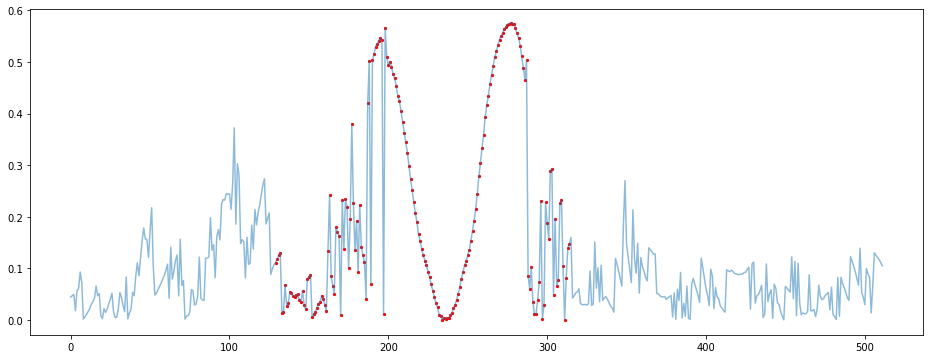

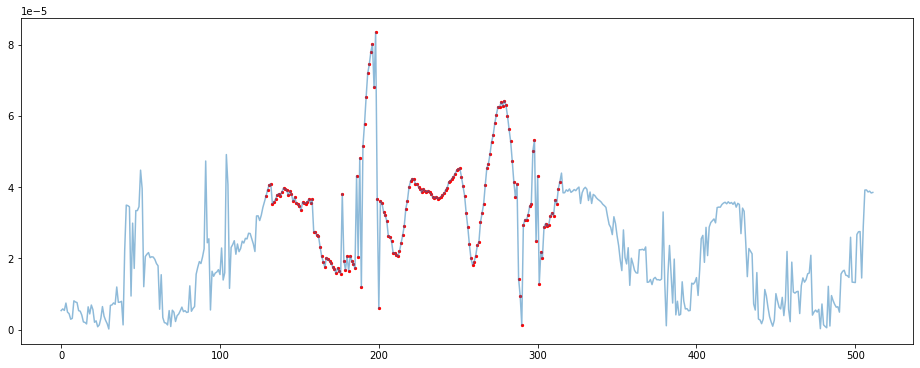

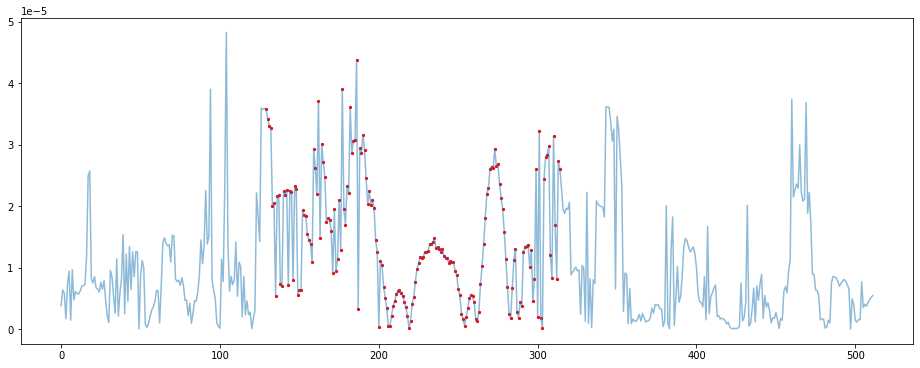

In [61]:
diff = (y - x).abs().cpu().detach().numpy()

plt.figure(figsize=(16, 6))
plt.plot(diff[0, :, 0], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 0], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(diff[0, :, 1], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 1], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(diff[0, :, 2], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 2], color='red', s=5)
plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(diff[0, :, 3], alpha=0.5)
# plt.scatter(anomaly_args, diff[0, anomaly_args, 3], color='red', s=5)
# plt.show()

In [62]:
print('l1 loss :', l1_loss(x, y).item())
print('mse loss :', mse(x, y).item())

l1 loss : 0.0051821814849972725
mse loss : 0.0014712405391037464


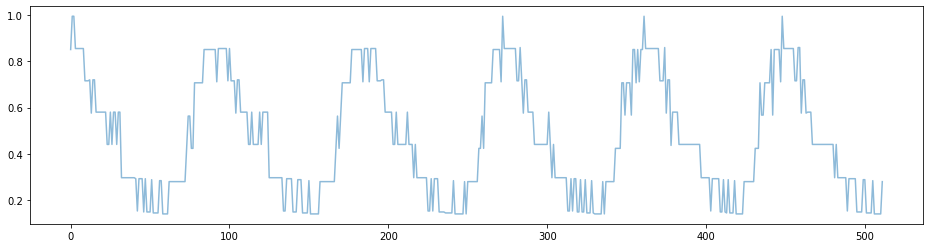

In [63]:
# Normal data
test_x = test_smap[14000:14512]
test_label = test_label_smap[14000:14512]
anomaly_args = np.argwhere(test_label).flatten()

plt.figure(figsize=(16, 4))
plt.plot(test_x[:, 0], alpha=0.5)
plt.scatter(anomaly_args, test_x[anomaly_args, 0], color='red', s=5)
plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 1], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 1], color='red', s=5)
# plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 2], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 2], color='red', s=5)
# plt.show()

# plt.figure(figsize=(16, 8))
# plt.plot(test_x[:, 3], alpha=0.5)
# plt.scatter(anomaly_args, test_x[anomaly_args, 3], color='red', s=5)
# plt.show()

In [64]:
with torch.no_grad():
    x = torch.Tensor(test_x).unsqueeze(0).to(device)
    y, scores = model(x)
    anomaly = torch.Tensor(test_label).unsqueeze(0).to(device)

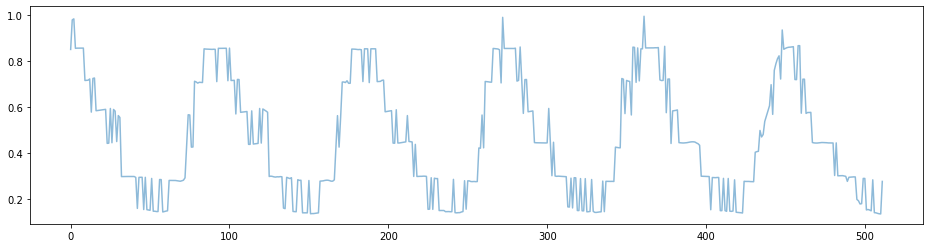

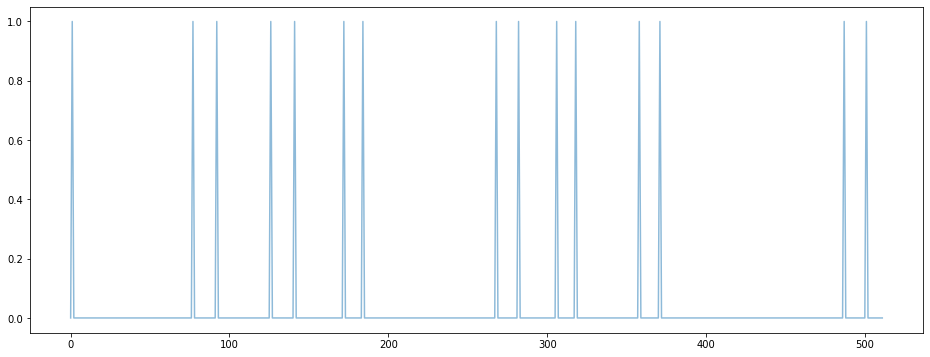

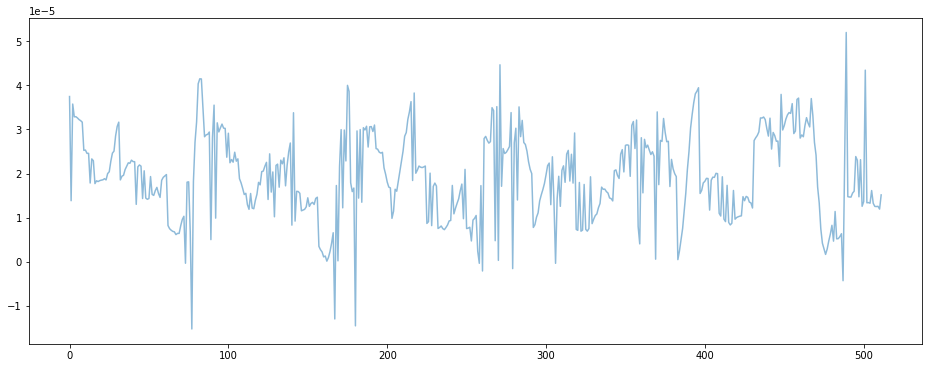

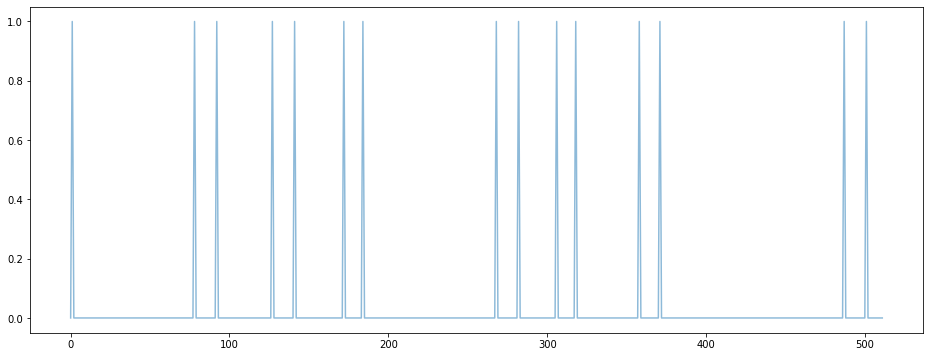

In [65]:
plt.figure(figsize=(16, 4))
plt.plot(y[0, :, 0].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 0].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(y[0, :, 1].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 1].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(y[0, :, 2].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 2].cpu().detach().numpy(), color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(y[0, :, 3].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 3].cpu().detach().numpy(), color='red', s=5)
plt.show()

# plt.figure(figsize=(16, 4))
# # plt.ylim((0, 0.005))
# plt.plot(scores[0].cpu().detach().numpy(), alpha=0.5)
# plt.scatter(anomaly_args, scores[0, anomaly_args].cpu().detach().numpy(), color='red', s=5)
# plt.show()

# print(scores[0, 256])

# sim_map = similarity_map(scores)
# draw_map(sim_map)
# draw_map(sim_map > 0.95)
# print(sim_map.min())

# sim_sum = sim_map.sum(dim=-1)
# plt.figure(figsize=(16, 6))
# plt.plot(sim_sum[0].numpy(), alpha=0.5)
# plt.scatter(anomaly_args, sim_sum[0, anomaly_args], color='red', s=5)
# plt.show()

# print(sim_sum.sum())
# print(torch.exp(sim_map).sum())
# print(torch.exp(-sim_map).sum())

# sim_sum = (sim_map > 0.5).sum(dim=-1)
# plt.figure(figsize=(16, 6))
# plt.plot(sim_sum[0].numpy())
# plt.show()

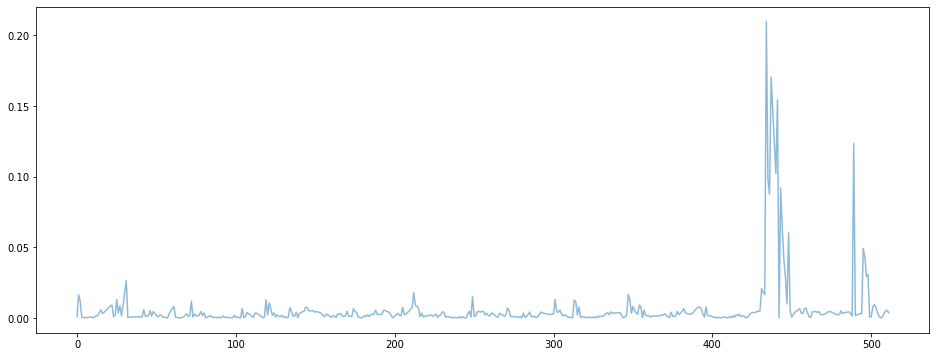

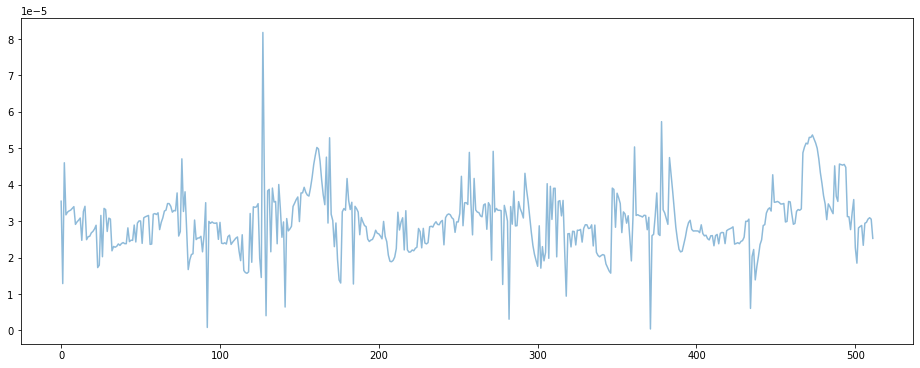

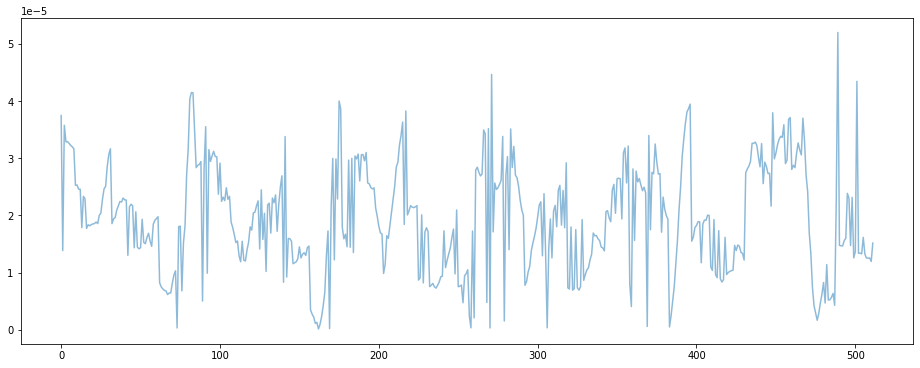

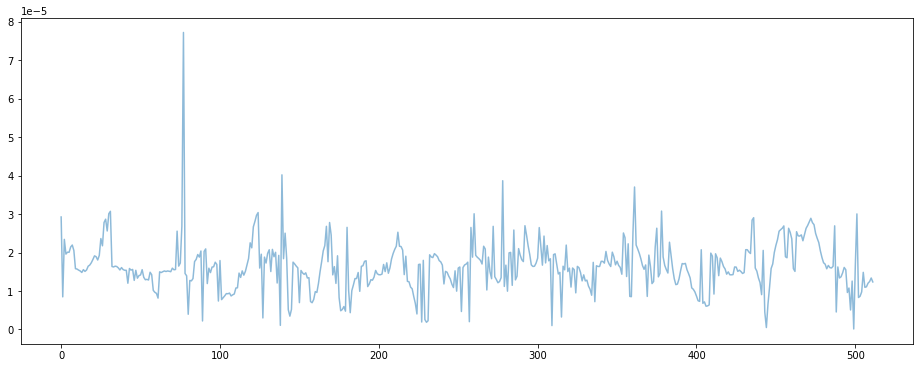

In [66]:
diff = (y - x).abs().cpu().detach().numpy()

plt.figure(figsize=(16, 6))
plt.plot(diff[0, :, 0], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 0], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(diff[0, :, 1], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 1], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(diff[0, :, 2], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 2], color='red', s=5)
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(diff[0, :, 3], alpha=0.5)
plt.scatter(anomaly_args, diff[0, anomaly_args, 3], color='red', s=5)
plt.show()

In [67]:
print('l1 loss :', l1_loss(x, y).item())
print('mse loss :', mse(x, y).item())

l1 loss : 0.000271076918579638
mse loss : 1.6529726053704508e-05


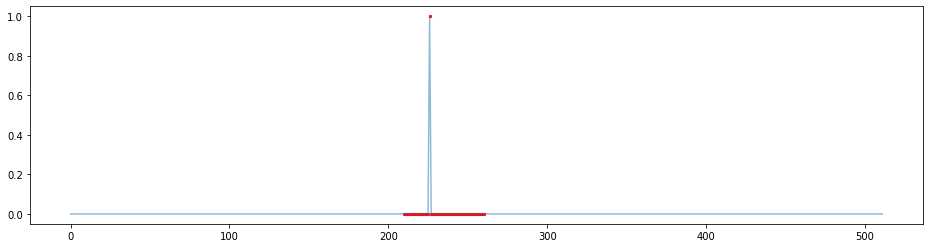

In [75]:
# 385500:386012

test_x = test_smap[137000:137512]
test_label = test_label_smap[137000:137512]
anomaly_args = np.argwhere(test_label).flatten()

plt.figure(figsize=(16, 4))
plt.plot(test_x[:, 0], alpha=0.5)
# for i in range(25):
#     plt.plot(test_x[:, i], alpha=0.5)
plt.scatter(anomaly_args, test_x[anomaly_args, 0], color='red', s=5)
plt.show()

In [76]:
with torch.no_grad():
    x = torch.Tensor(test_x).unsqueeze(0).to(device)
    y, scores = model(x)
    anomaly = torch.Tensor(test_label).unsqueeze(0).to(device)

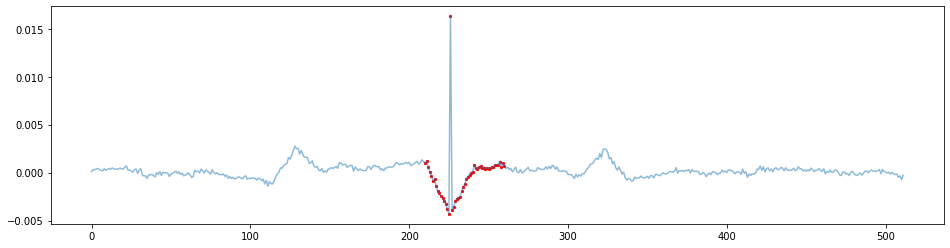

In [77]:
plt.figure(figsize=(16, 4))
plt.plot(y[0, :, 0].cpu().detach().numpy(), alpha=0.5)
plt.scatter(anomaly_args, y[0, anomaly_args, 0].cpu().detach().numpy(), color='red', s=5)
plt.show()

In [3]:
df = pd.read_csv('logs/220602142216_smap_test/state_dict_eval.csv', index_col=False).drop(columns='Unnamed: 0')
df.head()

,pointwise_L1,pointwise_L2,prod_L2_area_1,prod_L2_area_2,prod_L2_area_3,window-wise_L1,window-wise_L2,Frobenius,area_between_curves,mse_area,L1_area_dim_1,L2_area_dim_1,anomaly_label
0,0.000600,0.000600,0.001217,0.002470,0.005011,0.004653,0.003504,1.414511,1.465032,2.029011,0.382515,0.029011,False
1,0.000397,0.000397,0.000805,0.001633,0.003312,0.004654,0.003504,1.414511,1.465055,2.028997,0.382605,0.028997,False
2,0.000493,0.000493,0.001000,0.002029,0.004116,0.004653,0.003504,1.414511,1.465004,2.029004,0.382411,0.029004,False
3,0.000547,0.000547,0.001109,0.002251,0.004566,0.004653,0.003504,1.414511,1.464991,2.029015,0.382359,0.029015,False
4,2.002589,1.414216,2.869470,5.822209,11.813372,0.004653,0.003503,1.414511,1.464921,2.029019,0.382091,0.029019,False


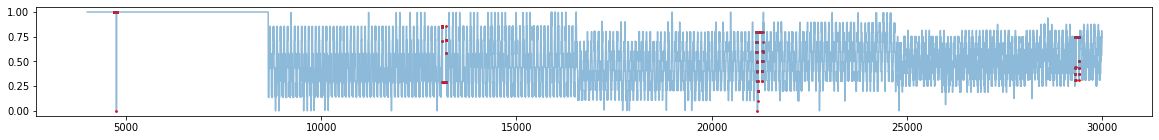

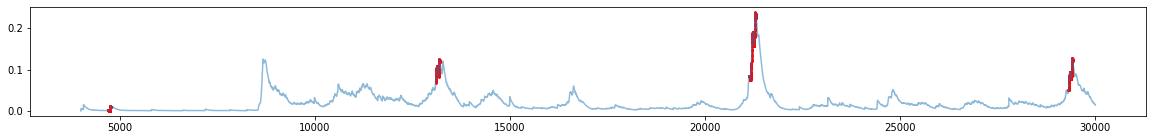

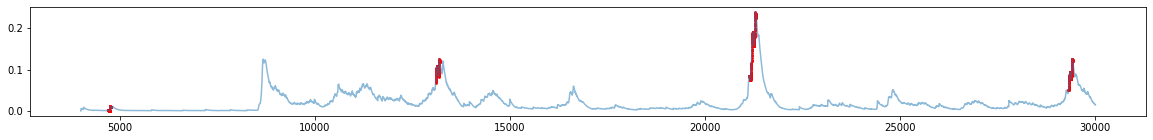

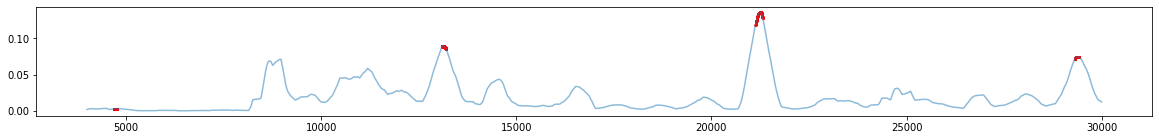

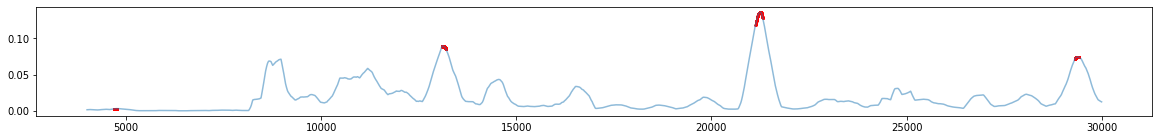

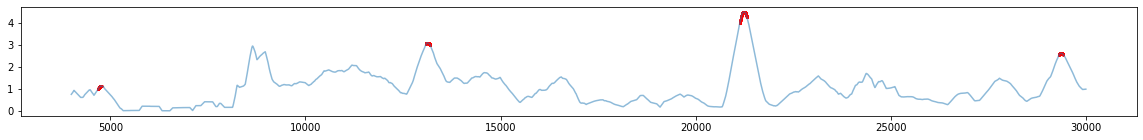

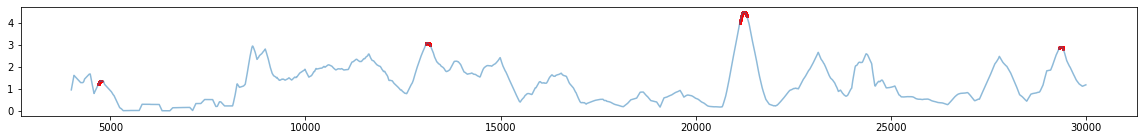

In [18]:
# 427617
(first_step, last_step) = (4000, 30000)
df_temp = df.iloc[first_step:last_step]
anomaly_args = np.argwhere(df_temp['anomaly_label'].to_numpy()).flatten()

plt.figure(figsize=(20, 2))
plt.plot(range(first_step, last_step), test_smap[first_step:last_step, 0], alpha=0.5)
plt.scatter(anomaly_args+first_step, test_smap[first_step:last_step, 0][anomaly_args], color='red', s=3)
plt.show()

pointwise_L1 = ewma(df_temp['pointwise_L1'], 0.99)
plt.figure(figsize=(20, 2))
plt.plot(np.arange(first_step,last_step), pointwise_L1, alpha=0.5)
plt.scatter(anomaly_args+first_step, pointwise_L1[anomaly_args], color='red', s=3)
plt.show()

pointwise_L2 = ewma(df_temp['pointwise_L2'], 0.99)
plt.figure(figsize=(20, 2))
plt.plot(np.arange(first_step,last_step), pointwise_L2, alpha=0.5)
plt.scatter(anomaly_args+first_step, pointwise_L2[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df_temp['window-wise_L1'], alpha=0.5)
plt.scatter(anomaly_args+first_step, df_temp['window-wise_L1'].iloc[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df_temp['window-wise_L2'], alpha=0.5)
plt.scatter(anomaly_args+first_step, df_temp['window-wise_L2'].iloc[anomaly_args], color='red', s=3)
plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df_temp['prod_L2_area_1'], alpha=0.5)
# plt.scatter(anomaly_args+first_step, df_temp['prod_L2_area_1'].iloc[anomaly_args], color='red', s=3)
# plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df_temp['prod_L2_area_2'], alpha=0.5)
# plt.scatter(anomaly_args+first_step, df_temp['prod_L2_area_2'].iloc[anomaly_args], color='red', s=3)
# plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df_temp['prod_L2_area_3'], alpha=0.5)
# plt.scatter(anomaly_args+first_step, df_temp['prod_L2_area_3'].iloc[anomaly_args], color='red', s=3)
# plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df_temp['Frobenius'], alpha=0.5)
plt.scatter(anomaly_args+first_step, df_temp['Frobenius'].iloc[anomaly_args], color='red', s=3)
plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df_temp['area_between_curves'], alpha=0.5)
# plt.scatter(anomaly_args+first_step, df_temp['area_between_curves'].iloc[anomaly_args], color='red', s=3)
# plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df_temp['mse_area'], alpha=0.5)
plt.scatter(anomaly_args+first_step, df_temp['mse_area'].iloc[anomaly_args], color='red', s=3)
plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df_temp['L1_area_dim_1'], alpha=0.5)
# plt.scatter(anomaly_args+first_step, df_temp['L1_area_dim_1'].iloc[anomaly_args], color='red', s=3)
# plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df_temp['L2_area_dim_1'], alpha=0.5)
# plt.scatter(anomaly_args+first_step, df_temp['L2_area_dim_1'].iloc[anomaly_args], color='red', s=3)
# plt.show()

In [12]:
def ewma(series, weighting_factor=0.1):
    current_factor = 1 - weighting_factor
    _ewma = series.to_numpy().copy()
    for i in range(1, len(_ewma)):
        _ewma[i] = _ewma[i-1] * weighting_factor + _ewma[i] * current_factor
    return _ewma

In [45]:
print('total data :', len(df_temp))

df_labels = df_temp['anomaly_label']

print('anomaly :', len(df_labels[df_labels]))
print('anomaly rate :', len(df_labels[df_labels]) / len(df_temp))

total data : 427617
anomaly : 54696
anomaly rate : 0.12790885301566587


In [190]:
rates = np.array([0.05, 0.1, 0.1279, 0.15, 0.2, 0.5])
interval = len(df_temp)

columns = df_temp.columns[:-1]
# columns = list(df_temp.columns[:6])
# columns.append('L2_area_1')

for column in columns:
    n_anomalies = np.zeros_like(rates)
    for j in range(0, len(df_temp), interval):
        df_sort = df_temp[[column, 'anomaly_label']].iloc[j:j+interval]
        df_sort = df_sort.sort_values(by=column, ascending=False)
        n_tops = (rates * len(df_sort)).astype(int)
        for i, n_top in enumerate(n_tops):
            n_anomaly = df_sort.iloc[:n_top, 1]
            n_anomaly = len(n_anomaly[n_anomaly])
            n_anomalies[i] += n_anomaly
    for rate, j in zip(rates, n_anomalies):
        print(j, '({:.4f}%)'.format(j/len(df_labels[df_labels])*100), 'anomaly in', int(rate*len(df_temp)), 'highest data by', column)
    print()

691.0 (28.7917%) anomaly in 2500 highest data by pointwise_L1
1351.0 (56.2917%) anomaly in 5000 highest data by pointwise_L1
1559.0 (64.9583%) anomaly in 6395 highest data by pointwise_L1
1681.0 (70.0417%) anomaly in 7500 highest data by pointwise_L1
1925.0 (80.2083%) anomaly in 10000 highest data by pointwise_L1
2320.0 (96.6667%) anomaly in 25000 highest data by pointwise_L1

697.0 (29.0417%) anomaly in 2500 highest data by pointwise_L2
1356.0 (56.5000%) anomaly in 5000 highest data by pointwise_L2
1565.0 (65.2083%) anomaly in 6395 highest data by pointwise_L2
1686.0 (70.2500%) anomaly in 7500 highest data by pointwise_L2
1933.0 (80.5417%) anomaly in 10000 highest data by pointwise_L2
2320.0 (96.6667%) anomaly in 25000 highest data by pointwise_L2

441.0 (18.3750%) anomaly in 2500 highest data by prod_L2_area_1
1052.0 (43.8333%) anomaly in 5000 highest data by prod_L2_area_1
1328.0 (55.3333%) anomaly in 6395 highest data by prod_L2_area_1
1552.0 (64.6667%) anomaly in 7500 highest data

In [164]:
rates = np.array([0.05, 0.1, 0.1279, 0.15, 0.2, 0.5])
n_tops = (rates * len(df_temp)).astype(int)

# ptwise_columns = ['L1_production', 'L2_production']
columns = df_temp.columns[2:-1]

for column in columns:
    product = (df_temp[column] ** 3) * df_temp['pointwise_L2']
    df_sort = pd.DataFrame({'anomaly': df_temp['anomaly_label'],
                            'product': product})\
                .sort_values(by='product', ascending=False)
    for n_top, rate in zip(n_tops, rates):
        n_anomaly = df_sort.iloc[:n_top, 0]
        n_anomaly = len(n_anomaly[n_anomaly])
        print(n_anomaly, '({:.4f}%)'.format(n_anomaly/len(df_labels[df_labels])*100), 'anomaly in', n_top, 'highest data by', column)
    print()

490 (20.4167%) anomaly in 2500 highest data by prod_L2_area_1
1151 (47.9583%) anomaly in 5000 highest data by prod_L2_area_1
1419 (59.1250%) anomaly in 6395 highest data by prod_L2_area_1
1615 (67.2917%) anomaly in 7500 highest data by prod_L2_area_1
1873 (78.0417%) anomaly in 10000 highest data by prod_L2_area_1
2325 (96.8750%) anomaly in 25000 highest data by prod_L2_area_1

417 (17.3750%) anomaly in 2500 highest data by prod_L2_area_2
793 (33.0417%) anomaly in 5000 highest data by prod_L2_area_2
1145 (47.7083%) anomaly in 6395 highest data by prod_L2_area_2
1342 (55.9167%) anomaly in 7500 highest data by prod_L2_area_2
1730 (72.0833%) anomaly in 10000 highest data by prod_L2_area_2
2320 (96.6667%) anomaly in 25000 highest data by prod_L2_area_2

406 (16.9167%) anomaly in 2500 highest data by prod_L2_area_3
687 (28.6250%) anomaly in 5000 highest data by prod_L2_area_3
816 (34.0000%) anomaly in 6395 highest data by prod_L2_area_3
1016 (42.3333%) anomaly in 7500 highest data by prod_L2

In [37]:
# Frob, 24.5%, 1 class
n_class = 1
(first_step, last_step) = (75469, 171132)
division = (last_step - first_step) // n_class
division = list(range(first_step, first_step + division * n_class, division))

# columns = df_temp.columns[5:-3]
columns = ['window-wise_L1', 'window-wise_L2', 'Frobenius', 'mse_area']

# rates = np.arange(0.03, 0.25, 0.01)
rates = np.arange(0.05, 0.251, 0.005)

precision = np.zeros((len(columns), len(rates), n_class))
recall = np.zeros_like(precision)

for i, first_step, last_step in zip(range(n_class), division, division[1:]+[last_step]):
    df_temp = df.iloc[first_step:last_step]
    anomaly_args = np.argwhere(df_temp['anomaly_label'].to_numpy()).flatten()
    
    n_tops = (rates * len(df_temp)).astype(int)

    anomaly_seq_list = []

    for column in columns:
#         values = df_temp['pointwise_L2']
#         values = (df_temp['pointwise_L2'] * (df_temp[column] ** 8))
        values = df_temp[column]
        values = ewma(values, 0.95)

#         plt.figure(figsize=(20, 2))
#         plt.plot(values, alpha=0.5)
#         plt.scatter(anomaly_args, values[anomaly_args], color='red', s=3)
#     #     plt.ylim(0, 100)
#         plt.show()

    #     df_sort = values.sort_values(ascending=False).to_numpy()
        df_sort = np.sort(values)[::-1]
    #     values = values.to_numpy()
        column_anomaly = []

        for n_top, rate in zip(n_tops, rates):
            thres = df_sort[n_top]
            anomaly_pts = np.argwhere(values > thres).flatten()
            terms = anomaly_pts[1:] - anomaly_pts[:-1]
            terms = terms > 1

            sequence_args = np.argwhere(terms).flatten() + 1
            sequence_length = list(sequence_args[1:] - sequence_args[:-1])
            sequence_args = list(sequence_args)

            sequence_args.insert(0, 0)
            if len(sequence_args) > 1:
                sequence_length.insert(0, sequence_args[1])
            sequence_length.append(len(anomaly_args) - sequence_args[-1])

            sequence_args = anomaly_pts[sequence_args]
            _sequence_args = sequence_args + np.array(sequence_length)

            column_anomaly.append(np.array((sequence_args, _sequence_args)))

        anomaly_seq_list.append(column_anomaly)
        
    anomaly_args = np.argwhere(df_temp['anomaly_label'].to_numpy()).flatten()
    terms = anomaly_args[1:] - anomaly_args[:-1]
    terms = terms > 1

    sequence_args = np.argwhere(terms).flatten() + 1
    sequence_length = list(sequence_args[1:] - sequence_args[:-1])
    sequence_args = list(sequence_args)

    sequence_args.insert(0, 0)
    if len(sequence_args) > 1:
        sequence_length.insert(0, sequence_args[1])
    sequence_length.append(len(anomaly_args) - sequence_args[-1])

    sequence_args = anomaly_args[sequence_args]
    anomaly_label_seq = np.transpose(np.array((sequence_args, sequence_args + np.array(sequence_length))))

#     print('<Division {}>'.format(first_step))
    print('# anomalies :', len(anomaly_label_seq))
    for _seq in anomaly_label_seq:
        print(_seq, _seq[1]-_seq[0])
    print()
#     print()

    for j, column, column_anomaly in zip(range(len(columns)), columns, anomaly_seq_list):
#         print('<{}>'.format(column))
        for k, rate, seq in zip(range(len(rates)), rates, column_anomaly):
            overlap_table = (seq[[0]] < anomaly_label_seq[:, [1]]) & (seq[[1]] > anomaly_label_seq[:, [0]])
            overlap_table = overlap_table.astype(int)

            _precision = overlap_table.sum(axis=0) > 0
            precision[j, k, i] = len(_precision[_precision]) / len(_precision)

            _recall = overlap_table.sum(axis=1) > 0
            recall[j, k, i] = len(_recall[_recall]) / len(_recall)

#             f1 = 2 / (1 / precision + 1 / recall)

#             print('{:5.02f}%,  '.format(rate*100), end='')
#             print('seq_len : {:3d},  '.format(len(seq[0])), end='')
#             print('P : {:.04f},  '.format(precision), end='')
#             print('R : {:.04f},  '.format(recall), end='')
#             print('F1 : {:.04f}'.format(f1))
#         print()
#     print()

precision = precision.mean(axis=-1)
recall = recall.mean(axis=-1)

print(precision)
print()
print(recall)
print()
f1 = 2 / (1 / precision + 1 / recall)
print(f1)
print()
print(f1.max())

# anomalies : 12
[5250 8509] 3259
[12779 12840] 61
[21118 23858] 2740
[28928 29089] 161
[35840 40058] 4218
[45341 48617] 3276
[53981 57229] 3248
[62029 62080] 51
[69727 69808] 81
[77681 80383] 2702
[84753 84804] 51
[94507 95663] 1156

[[0.75       0.75       0.76470588 0.76470588 0.76470588 0.68421053
  0.65       0.72222222 0.72222222 0.73684211 0.72222222 0.73684211
  0.72222222 0.72222222 0.75       0.75       0.76190476 0.76190476
  0.71428571 0.77272727 0.7826087  0.7826087  0.77272727 0.76190476
  0.76       0.75       0.75       0.71428571 0.72727273 0.68421053
  0.66666667 0.63157895 0.65       0.66666667 0.61904762 0.61904762
  0.61904762 0.52380952 0.54545455 0.52380952 0.52380952]
 [0.75       0.75       0.75       0.76470588 0.70588235 0.70588235
  0.75       0.76470588 0.76470588 0.75       0.75       0.77777778
  0.75       0.75       0.76190476 0.75       0.71428571 0.77272727
  0.77272727 0.79166667 0.7826087  0.77272727 0.77272727 0.79166667
  0.79166667 0.79166667 0.7

In [103]:
anomaly_args = np.argwhere(df_temp['anomaly_label'].to_numpy()).flatten()
terms = anomaly_args[1:] - anomaly_args[:-1]
terms = terms > 1

sequence_args = np.argwhere(terms).flatten() + 1
sequence_length = list(sequence_args[1:] - sequence_args[:-1])
sequence_args = list(sequence_args)

sequence_args.insert(0, 0)
sequence_length.insert(0, sequence_args[1])
sequence_length.append(len(anomaly_args) - sequence_args[-1])

sequence_args = anomaly_args[sequence_args]
anomaly_label_seq = np.transpose(np.array((sequence_args, sequence_args + np.array(sequence_length))))

print('# anomalies :', len(anomaly_label_seq))
print()

for column, column_anomaly in zip(columns, anomaly_seq_list):
    print('<{}>'.format(column))
    for rate, seq in zip(rates, column_anomaly):
        overlap_table = (seq[[0]] < anomaly_label_seq[:, [1]]) & (seq[[1]] > anomaly_label_seq[:, [0]])
        overlap_table = overlap_table.astype(int)
        
        precision = overlap_table.sum(axis=0) > 0
        precision = len(precision[precision]) / len(precision)
        
        recall = overlap_table.sum(axis=1) > 0
        recall = len(recall[recall]) / len(recall)
        
        f1 = 2 / (1 / precision + 1 / recall)
        
        print('{:5.02f}%,  '.format(rate*100), end='')
        print('seq_len : {:3d},  '.format(len(seq[0])), end='')
        print('P : {:.04f},  '.format(precision), end='')
        print('R : {:.04f},  '.format(recall), end='')
        print('F1 : {:.04f}'.format(f1))
    print()

# anomalies : 67

<window-wise_L1>
 5.00%,  seq_len :  24,  P : 0.5417,  R : 0.2537,  F1 : 0.3456
 6.00%,  seq_len :  26,  P : 0.5000,  R : 0.2687,  F1 : 0.3495
 7.00%,  seq_len :  27,  P : 0.6296,  R : 0.3134,  F1 : 0.4185
 8.00%,  seq_len :  26,  P : 0.6923,  R : 0.3284,  F1 : 0.4454
 9.00%,  seq_len :  34,  P : 0.7353,  R : 0.4030,  F1 : 0.5206
10.00%,  seq_len :  45,  P : 0.6889,  R : 0.4478,  F1 : 0.5427
11.00%,  seq_len :  51,  P : 0.6471,  R : 0.4627,  F1 : 0.5396
12.00%,  seq_len :  55,  P : 0.6182,  R : 0.4776,  F1 : 0.5389
13.00%,  seq_len :  62,  P : 0.6290,  R : 0.5224,  F1 : 0.5708
14.00%,  seq_len :  65,  P : 0.6000,  R : 0.5373,  F1 : 0.5669
15.00%,  seq_len :  70,  P : 0.5857,  R : 0.5522,  F1 : 0.5685
16.00%,  seq_len :  75,  P : 0.5467,  R : 0.5522,  F1 : 0.5494
17.00%,  seq_len :  71,  P : 0.6056,  R : 0.5821,  F1 : 0.5936
18.00%,  seq_len :  79,  P : 0.5823,  R : 0.5970,  F1 : 0.5896
19.00%,  seq_len :  84,  P : 0.5714,  R : 0.6119,  F1 : 0.5910
20.00%,  seq_len :  

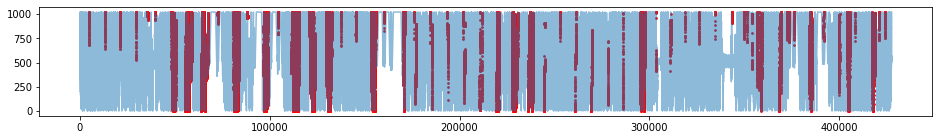

In [139]:
# column = 'mse_area'
product = (df_temp[column] ** 3) * df_temp['pointwise_L2']
values = product.to_numpy()
_values = product.iloc[512:].to_list()
_values.extend(np.zeros(512))
queue = [0] * 511
queue.extend(values[:512])
queue = np.array(queue)
local_sort = []
index = 0
max_index = 1023

for value, _value in zip(values, _values):
    lower = queue <= value
    lower = len(lower[lower])
    local_sort.append(lower)
    queue[index] = _value
    index += 1
    if index == max_index:
        index = 0
local_sort = np.array(local_sort)
        
plt.figure(figsize=(16, 2))
plt.plot(local_sort, alpha=0.5)
plt.scatter(anomaly_args, local_sort[anomaly_args], color='red', s=3)
plt.show()

In [141]:
rates = np.array([0.05, 0.1, 0.1279, 0.15, 0.2, 0.5])
n_tops = (rates * len(test_label_smap)).astype(int)

valid_sorted = local_sort.copy()
valid_sorted[values < sorted(values)[int(len(values) * 0.1)]] = 0

for n_top in n_tops:
    weighted_values = df_temp[column].to_numpy() * valid_sorted
    thres = sorted(weighted_values)[-n_top]

    over_thres = weighted_values > thres
    detected = df_temp.iloc[over_thres, -1]
    n_detected = len(detected[detected])
    n_over_thres = len(over_thres[over_thres])
    print(n_detected, n_over_thres, n_detected / n_over_thres)

4615 21379 0.2158660367650498
9496 42760 0.22207670720299344
11547 54691 0.21113163043279515
13063 64141 0.20366068505324209
16669 85522 0.19490891232665278
34968 213807 0.1635493692909961


In [6]:
tot_ano = 54696
n_query = [21380, 42761, 54692, 64142, 85523]

pt_l2 = [5594,11824,14687,16662,20401]
mse = [6060,10612,14703,16536,19009]
ano_ind = [7920,13355,15485,16897,20594]

for _val in zip(pt_l2, mse, ano_ind, n_query):
    for val in _val[:-1]:
        prec = val/_val[-1]
        reca = val/tot_ano
        f1 = 2 / (1 / prec + 1 / reca)
        print('& {0:.04f} & {1:.04f} & {2:.04f} '.format(prec, reca, f1), end='')
    print()

& 0.2616 & 0.1023 & 0.1471 & 0.2834 & 0.1108 & 0.1593 & 0.3704 & 0.1448 & 0.2082 
& 0.2765 & 0.2162 & 0.2427 & 0.2482 & 0.1940 & 0.2178 & 0.3123 & 0.2442 & 0.2741 
& 0.2685 & 0.2685 & 0.2685 & 0.2688 & 0.2688 & 0.2688 & 0.2831 & 0.2831 & 0.2831 
& 0.2598 & 0.3046 & 0.2804 & 0.2578 & 0.3023 & 0.2783 & 0.2634 & 0.3089 & 0.2844 
& 0.2385 & 0.3730 & 0.2910 & 0.2223 & 0.3475 & 0.2711 & 0.2408 & 0.3765 & 0.2937 


In [40]:
# Find local maxima
for column in columns:
    val = df_temp[column]
    local_maxima = val[(val - val.shift(1, fill_value=0) > 0) & (val - val.shift(-1, fill_value=0) > 0)]
    
    top_90 = val.sort_values(ascending=False).iloc[int(0.5 * len(test_label_smap))]
    local_maxima = local_maxima[local_maxima > top_90]
    n_anomaly = df_temp.loc[local_maxima.index, 'anomaly_label']
    n_anomaly = len(n_anomaly[n_anomaly])
    
    print(len(local_maxima), n_anomaly)

1118 130
1081 141
1158 115
1127 150
1101 116
1205 166
1249 145


In [3]:
import json
with open('smap_test_class.json', 'r') as f:
    test_class = json.load(f)
print(test_class)

{'A': [0, 67425], 'B': [67425, 75469], 'D': [75469, 171132], 'E': [171132, 280750], 'F': [280750, 306336], 'G': [306336, 354374], 'P': [354374, 395435], 'R': [395435, 402679], 'S': [402679, 410010], 'T': [410010, 435826]}


In [23]:
import json
with open('smap_test_channel.json', 'r') as f:
    test_class = json.load(f)
print(test_class)

[[0, 8640], [8640, 16554], [16554, 24759], [24759, 32839], [32839, 37532], [37532, 41985], [41985, 50616], [50616, 58991], [58991, 67425], [67425, 75469], [75469, 83978], [83978, 92573], [92573, 101213], [101213, 109686], [109686, 117314], [117314, 125198], [125198, 132840], [132840, 140714], [140714, 148120], [148120, 155551], [155551, 163469], [163469, 171132], [171132, 179648], [179648, 188180], [188180, 196487], [196487, 204841], [204841, 213135], [213135, 221435], [221435, 229745], [229745, 238277], [238277, 246579], [246579, 255084], [255084, 263598], [263598, 272110], [272110, 280750], [280750, 289334], [289334, 297960], [297960, 306336], [306336, 314805], [314805, 322166], [322166, 330073], [330073, 337705], [337705, 346345], [346345, 354374], [354374, 362879], [362879, 371088], [371088, 379581], [379581, 387364], [387364, 395435], [395435, 402679], [402679, 410010], [410010, 418622], [418622, 427247], [427247, 435826]]


In [20]:
_class = 'E'
df = pd.read_csv('logs/220613225259_smap_test/state_dict_eval_class_'+_class+'.csv', index_col=False).drop(columns='Unnamed: 0')

first_step, last_step = test_class[_class]
anomaly_args = np.argwhere(df['anomaly_label'].to_numpy()).flatten()

In [137]:
channel = 22
df = pd.read_csv('logs/220613224859_smap_test/state_dict_eval_channel_{}.csv'.format(channel), index_col=False).drop(columns='Unnamed: 0')

first_step, last_step = test_class[channel]
anomaly_args = np.argwhere(df['anomaly_label'].to_numpy()).flatten()

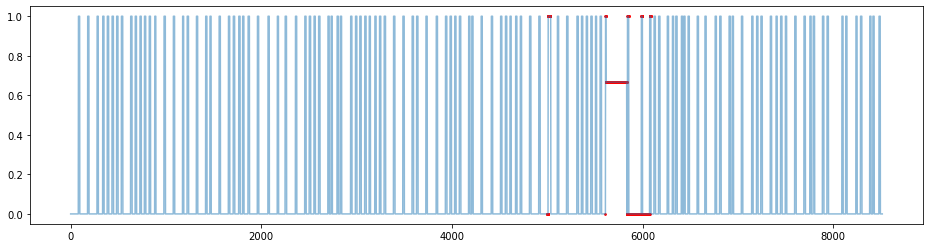

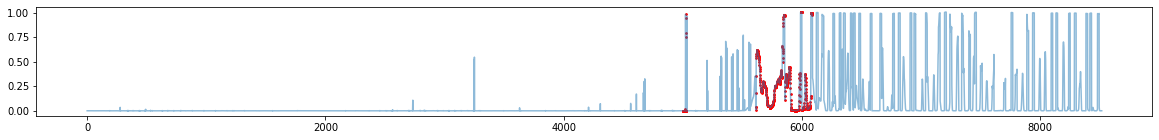

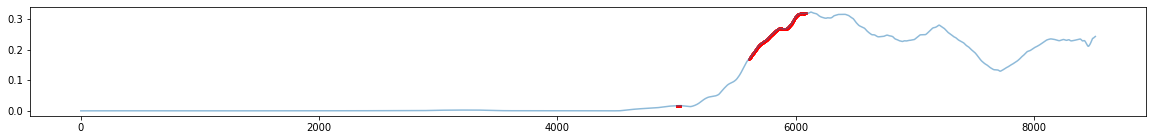

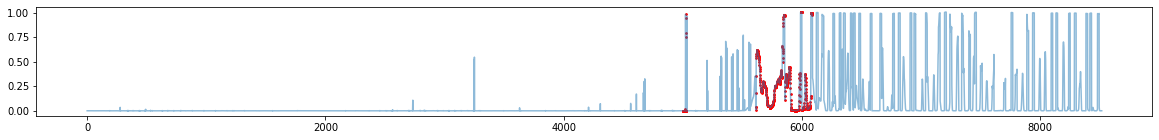

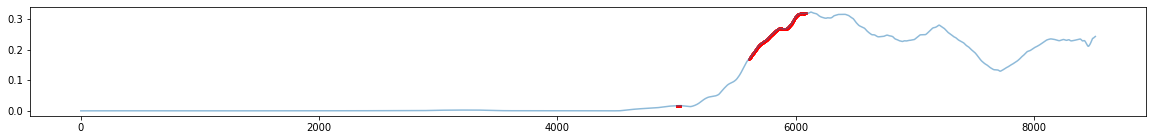

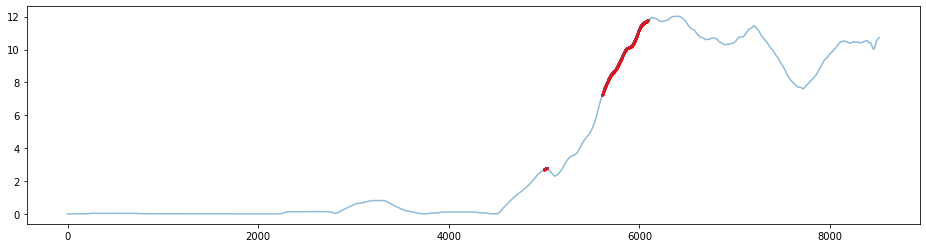

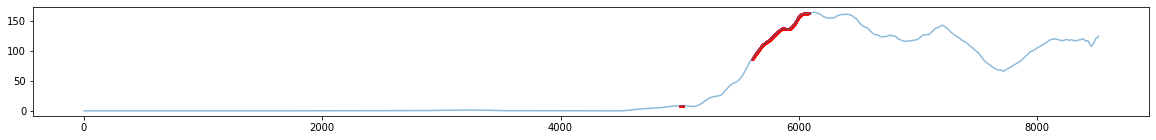

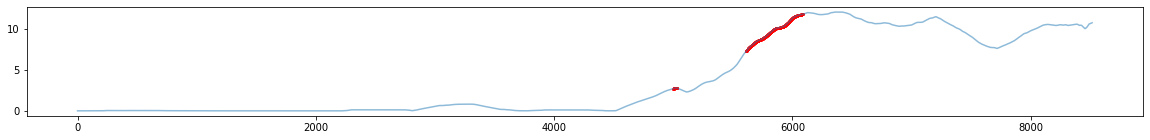

In [138]:
plt.figure(figsize=(16, 4))
plt.plot(test_smap[first_step:last_step, 0], alpha=0.5)
plt.scatter(anomaly_args, test_smap[first_step:last_step, 0][anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df['pointwise_L1'], alpha=0.5)
plt.scatter(anomaly_args, df['pointwise_L1'].iloc[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df['window-wise_L1'], alpha=0.5)
plt.scatter(anomaly_args, df['window-wise_L1'].iloc[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df['pointwise_L2'], alpha=0.5)
plt.scatter(anomaly_args, df['pointwise_L2'].iloc[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df['window-wise_L2'], alpha=0.5)
plt.scatter(anomaly_args, df['window-wise_L2'].iloc[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(df['Frobenius'], alpha=0.5)
plt.scatter(anomaly_args, df['Frobenius'].iloc[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df['area_between_curves'], alpha=0.5)
plt.scatter(anomaly_args, df['area_between_curves'].iloc[anomaly_args], color='red', s=3)
plt.show()

plt.figure(figsize=(20, 2))
plt.plot(df['mse_area'], alpha=0.5)
plt.scatter(anomaly_args, df['mse_area'].iloc[anomaly_args], color='red', s=3)
plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df['L1_area_dim_1'], alpha=0.5)
# plt.scatter(anomaly_args, df['L1_area_dim_1'].iloc[anomaly_args], color='red', s=3)
# plt.show()

# plt.figure(figsize=(16, 2))
# plt.plot(df['L2_area_dim_1'], alpha=0.5)
# plt.scatter(anomaly_args, df['L2_area_dim_1'].iloc[anomaly_args], color='red', s=3)
# plt.show()

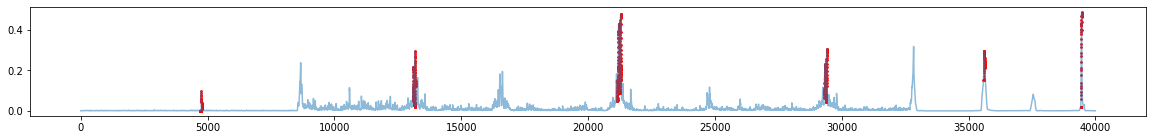

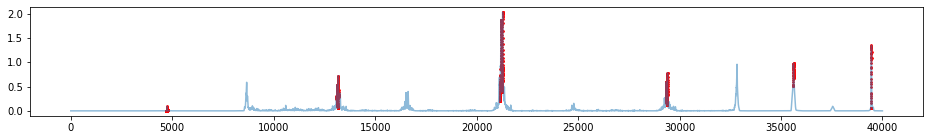

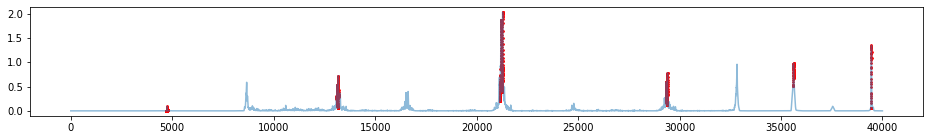

In [15]:
pointwise_L2 = ewma(df['pointwise_L1'], 0.9)
plt.figure(figsize=(20, 2))
plt.plot(pointwise_L2 , alpha=0.5)
plt.scatter(anomaly_args, pointwise_L2[anomaly_args], color='red', s=3)
plt.show()

values = (df['Frobenius'] ** 1) * pointwise_L2
plt.figure(figsize=(16, 2))
plt.plot(values , alpha=0.5)
plt.scatter(anomaly_args, values[anomaly_args], color='red', s=3)
plt.show()

values = (df['mse_area'] ** 1) * pointwise_L2
plt.figure(figsize=(16, 2))
plt.plot(values , alpha=0.5)
plt.scatter(anomaly_args, values[anomaly_args], color='red', s=3)
# plt.ylim((0, 10))
plt.show()

In [12]:
def ewma(series, weighting_factor=0.1):
    current_factor = 1 - weighting_factor
    _ewma = series.to_numpy().copy()
    for i in range(1, len(_ewma)):
        _ewma[i] = _ewma[i-1] * weighting_factor + _ewma[i] * current_factor
    return _ewma

In [32]:
def custom_ewma(series, weighting_factor=0.1, average_range=100):
    weight = np.arange(1, average_range)
    weight = np.exp(weight * np.log(weighting_factor))
    
    current_factor = 1 - weighting_factor
    _ewma = series.to_numpy().copy()
    _series = _ewma.copy()
    for i in range(1, len(_ewma)):
        series_range = _series[i+1:i+average_range]
        _ewma[i] += np.dot(series_range, weight[:len(series_range)])
        series_range = _series[np.max(i-average_range+1,0):i]
        _ewma[i] += np.dot(series_range, weight[len(series_range)-1::-1]) if len(series_range) > 0 else 0
    return _ewma

In [99]:
# Frob, 24.5%, 1 class
columns = ['window-wise_L1', 'window-wise_L2', 'Frobenius', 'mse_area']
rates = np.arange(0.01, 0.301, 0.01)
detected = np.zeros((len(columns), len(rates)))
true_detected_prec = np.zeros_like(detected)
true_detected_rec = np.zeros_like(detected)

df = pd.DataFrame()

# for _class, class_index in test_class.items():
#     df = pd.concat([df, pd.read_csv('logs/220613225259_smap_test/state_dict_eval_class_'+_class+'.csv', index_col=False)\
#                           .drop(columns='Unnamed: 0')])
#     df = pd.read_csv('logs/220613225259_smap_test/state_dict_eval_class_{}.csv'.format(_class), index_col=False).drop(columns='Unnamed: 0')
for channel, class_index in enumerate(test_class):
    df = pd.concat([df, pd.read_csv('logs/220613225259_smap_test/state_dict_eval_channel_{}.csv'.format(channel), index_col=False)\
                          .drop(columns='Unnamed: 0')])
#     df = pd.read_csv('logs/220613225259_smap_test/state_dict_eval_channel_{}.csv'.format(channel), index_col=False).drop(columns='Unnamed: 0')

# pointwise_L2 = ewma(df['pointwise_L2'], 0.9)

# 435826
n_class = 1
(first_step, last_step) = (0, 435826)
# (first_step, last_step) = (0, class_index[1]-class_index[0])
division = (last_step - first_step) // n_class
division = list(range(first_step, first_step + division * n_class, division))

precision = np.zeros((len(columns), len(rates), n_class))
recall = np.zeros_like(precision)

for i, first_step, last_step in zip(range(n_class), division, division[1:]+[last_step]):
    n_tops = (rates * len(df)).astype(int)
    anomaly_seq_list = []

    for column in columns:
#         values = pointwise_L2
        values = df[column].to_numpy()
#         values = (df[column].to_numpy() ** 3) * pointwise_L2

#         plt.figure(figsize=(20, 2))
#         plt.plot(values, alpha=0.5)
#         plt.scatter(anomaly_args, values[anomaly_args], color='red', s=3)
#     #     plt.ylim(0, 100)
#         plt.show()

    #     df_sort = values.sort_values(ascending=False).to_numpy()
        df_sort = np.sort(values)[::-1]

    #     values = values.to_numpy()
        column_anomaly = []

        for n_top, rate in zip(n_tops, rates):
            thres = df_sort[n_top]
            anomaly_pts = np.argwhere(values > thres).flatten()
            terms = anomaly_pts[1:] - anomaly_pts[:-1]
            terms = terms > 1

            sequence_args = np.argwhere(terms).flatten() + 1
            sequence_length = list(sequence_args[1:] - sequence_args[:-1])
            sequence_args = list(sequence_args)

            sequence_args.insert(0, 0)
            if len(sequence_args) > 1:
                sequence_length.insert(0, sequence_args[1])
            sequence_length.append(len(anomaly_pts) - sequence_args[-1])

            sequence_args = anomaly_pts[sequence_args]
            _sequence_args = sequence_args + np.array(sequence_length)

            column_anomaly.append(np.array((sequence_args, _sequence_args)))

        anomaly_seq_list.append(column_anomaly)

    anomaly_args = np.argwhere(df['anomaly_label'].to_numpy()).flatten()
    terms = anomaly_args[1:] - anomaly_args[:-1]
    terms = terms > 1

    sequence_args = np.argwhere(terms).flatten() + 1
    sequence_length = list(sequence_args[1:] - sequence_args[:-1])
    sequence_args = list(sequence_args)

    sequence_args.insert(0, 0)
    if len(sequence_args) > 1:
        sequence_length.insert(0, sequence_args[1])
    sequence_length.append(len(anomaly_args) - sequence_args[-1])

    sequence_args = anomaly_args[sequence_args]
    anomaly_label_seq = np.transpose(np.array((sequence_args, sequence_args + np.array(sequence_length))))

#     print('<Division {}>'.format(first_step))
#         print('# anomalies :', len(anomaly_label_seq))
#     print()

    for j, column, column_anomaly in zip(range(len(columns)), columns, anomaly_seq_list):
#         print('<{}>'.format(column))
        for k, rate, seq in zip(range(len(rates)), rates, column_anomaly):
            overlap_table = (seq[[0]] < anomaly_label_seq[:, [1]]) & (seq[[1]] > anomaly_label_seq[:, [0]])
            overlap_table = overlap_table.astype(int)

            _precision = overlap_table.sum(axis=0) > 0
            _recall = overlap_table.sum(axis=1) > 0

            detected[j, k] += len(_precision)
            true_detected_prec[j, k] += len(_precision[_precision])
            true_detected_rec[j, k] += len(_recall[_recall])

#                 precision[j, k, i] = len(_precision[_precision]) / len(_precision)

#                 _recall = overlap_table.sum(axis=1) > 0
#                 recall[j, k, i] = len(_recall[_recall]) / len(_recall)

#             f1 = 2 / (1 / precision + 1 / recall)

#             print('{:5.02f}%,  '.format(rate*100), end='')
#             print('seq_len : {:3d},  '.format(len(seq[0])), end='')
#             print('P : {:.04f},  '.format(precision), end='')
#             print('R : {:.04f},  '.format(recall), end='')
#             print('F1 : {:.04f}'.format(f1))
#         print()
#     print()


# print(true_detected_prec)
# print(detected)
# print()

print(rates)
    
precision = true_detected_prec / detected
recall = true_detected_rec / 68
print(precision)
print()
print(recall)
print()

f1 = 2 / (1 / (precision + 1e-9) + 1 / (recall + 1e-9))
print(f1)
print(f1.max())
print('\n')
    
#     precision = precision.mean(axis=-1)
#     recall = recall.mean(axis=-1)

#     print(precision)
#     print()
#     print(recall)
#     print()
#     f1 = 2 / (1 / (precision + 1e-9) + 1 / (recall + 1e-9))
#     for _f1 in f1:
#         print(_f1, '\n')
#     print(f1.max())
#     print('\n')

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3 ]
[[0.14285714 0.3125     0.55555556 0.5        0.55555556 0.86666667
  0.84       0.90909091 0.89473684 0.88888889 0.84444444 0.78846154
  0.67213115 0.71428571 0.66666667 0.58571429 0.56578947 0.61971831
  0.62162162 0.65753425 0.64197531 0.6        0.63414634 0.66666667
  0.64864865 0.55952381 0.56976744 0.55319149 0.57303371 0.59090909]
 [0.14285714 0.3125     0.55555556 0.5        0.55555556 0.86666667
  0.84       0.90909091 0.89473684 0.88888889 0.84444444 0.78846154
  0.67213115 0.71428571 0.66666667 0.58571429 0.56578947 0.61971831
  0.62162162 0.65753425 0.64197531 0.6        0.63414634 0.66666667
  0.64864865 0.55952381 0.56976744 0.55319149 0.57303371 0.59090909]
 [0.         0.25       0.55555556 0.88888889 0.7826087  0.85714286
  0.83333333 0.89473684 0.7826087  0.77083333 0.78       0.73214286
  0.64179104 0.62318841 0.67

In [96]:
l1_prec = precision[0]
l1_rec = recall[0]
l1_f1 = f1[0]

In [98]:
l2_prec = precision[0]
l2_rec = recall[0]
l2_f1 = f1[0]

In [108]:
for i, rate in enumerate(rates[::]):
    j = i
    print('{:.00f} '.format(rate * 100), end='&')
#     print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(l1_prec[j], l1_rec[j], l1_f1[j]), end='&')
    print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(l2_prec[j], l2_rec[j], l2_f1[j]), end='&')
#     print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(precision[0, j], recall[0, j], f1[0, j]), end='\\\\ \n')
    print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(precision[1, j], recall[1, j], f1[1, j]), end='&')
#     print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(precision[2, j], recall[2, j], f1[2, j]), end='&')
    print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(precision[3, j], recall[3, j], f1[3, j]), end='\\\\ \n')

1 & 0.2647 & 0.3529 & 0.3025 & 0.1429 & 0.0294 & 0.0488 & 0.0000 & 0.0000 & 0.0000 \\ 
2 & 0.3088 & 0.5294 & 0.3901 & 0.3125 & 0.0588 & 0.0990 & 0.2500 & 0.0294 & 0.0526 \\ 
3 & 0.3031 & 0.6176 & 0.4067 & 0.5556 & 0.1029 & 0.1737 & 0.5556 & 0.0735 & 0.1299 \\ 
4 & 0.3033 & 0.7353 & 0.4294 & 0.5000 & 0.1176 & 0.1905 & 0.8889 & 0.2059 & 0.3343 \\ 
5 & 0.3056 & 0.8235 & 0.4457 & 0.5556 & 0.1324 & 0.2138 & 0.7826 & 0.2500 & 0.3789 \\ 
6 & 0.2689 & 0.8529 & 0.4089 & 0.8667 & 0.1912 & 0.3133 & 0.8571 & 0.3235 & 0.4698 \\ 
7 & 0.2766 & 0.8971 & 0.4228 & 0.8400 & 0.2941 & 0.4357 & 0.8333 & 0.4265 & 0.5642 \\ 
8 & 0.2816 & 0.9118 & 0.4303 & 0.9091 & 0.3824 & 0.5383 & 0.8947 & 0.4706 & 0.6168 \\ 
9 & 0.2600 & 0.9118 & 0.4047 & 0.8947 & 0.4412 & 0.5910 & 0.7826 & 0.5000 & 0.6102 \\ 
10 & 0.2330 & 0.9118 & 0.3711 & 0.8889 & 0.4853 & 0.6278 & 0.7708 & 0.5147 & 0.6173 \\ 
11 & 0.1965 & 0.9118 & 0.3233 & 0.8444 & 0.4853 & 0.6164 & 0.7800 & 0.5441 & 0.6410 \\ 
12 & 0.1758 & 0.9118 & 0.2947 & 0.7885 & 

In [103]:
for i, rate in enumerate(rates[::4]):
    j = 4 * i
    print('{:.00f} '.format(rate * 100), end='&')
    print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(precision[1, j], recall[1, j], f1[1, j]), end='&')
    print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(precision[2, j], recall[2, j], f1[2, j]), end='&')
    print(' {0:.04f} & {1:.04f} & {2:.04f} '.format(precision[3, j], recall[3, j], f1[3, j]), end='\\\\ \n')

1 & 0.1429 & 0.0294 & 0.0488 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.0000 \\ 
5 & 0.5556 & 0.1324 & 0.2138 & 0.7826 & 0.2500 & 0.3789 & 0.7826 & 0.2500 & 0.3789 \\ 
9 & 0.8947 & 0.4412 & 0.5910 & 0.7826 & 0.5000 & 0.6102 & 0.7826 & 0.5000 & 0.6102 \\ 
13 & 0.6721 & 0.5147 & 0.5830 & 0.6418 & 0.5735 & 0.6057 & 0.6418 & 0.5735 & 0.6057 \\ 
17 & 0.5658 & 0.5588 & 0.5623 & 0.6622 & 0.6471 & 0.6545 & 0.6622 & 0.6471 & 0.6545 \\ 
21 & 0.6420 & 0.5882 & 0.6139 & 0.6420 & 0.7500 & 0.6918 & 0.6420 & 0.7500 & 0.6918 \\ 
25 & 0.6486 & 0.6324 & 0.6404 & 0.6923 & 0.8529 & 0.7643 & 0.6923 & 0.8529 & 0.7643 \\ 
29 & 0.5730 & 0.6912 & 0.6266 & 0.6882 & 0.8676 & 0.7676 & 0.6882 & 0.8676 & 0.7676 \\ 
